# SSW2023 Workshop 2 MIRI Solutions

## Author: Taylor Bell (Bay Area Environmental Research Institutite)

Run the [SWW2023_JWST_MIRI_NIRSpec_Setup](https://colab.research.google.com/drive/1fccr9FVwEsPhCzUhC4ah2FA9g0Q_AEMS?usp=sharing) notebook to download the data. The setup notebook needs to just be run **once** for both Hands-on I and II sessions.

# Google Colab Usage

*Please read (don't just hit run) the information given above each code cell as there are separate install cells for Colab*
&#128992;
*and running Python on your computer*
&#128309;.

**Confirm login account**
* Please make sure to be logged in with the Google account you want to use for the exercises before running the code cells below. You can check by clicking the circular account icon in the top right corner of the colab notebook.

**Working directory**
* Note: The data will be installed in a directory called "SSW2023" in your Google drive. This directory will be created if it does not exist.

**Running cells**
* Run cells individually by clicking on the triangle on each cell

**To Restart runtime**
*   Click on Runtime menu item
*   Select Restart runtime
*   Select Run code cells individually from the top

**To Recreate runtime**
*   Click on Runtime menu item
*   Select Disconnect and Delete runtime
*   Select Run code cells individually from the top

**To Exit:**
*   Close the browser window

# &#128992; Google Colab Setup and Installing Eureka!

**Important:** You will need to re-run these first two cells each time your runtime gets deleted.

&#128992; **This first cell will install Eureka!**

In [1]:
#If you are running this on your computer instead of Google Colab, you should instead follow the installation instructions at https://eurekadocs.readthedocs.io/en/latest/installation.html.# Change numpy version (required for theano)
!pip install numpy==1.21.6
# Install Eureka! (for now a dev branch, but in the future a stable branch)
!pip install eureka@git+https://github.com/kevin218/Eureka.git@dev/tjb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 35.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.6 which is incompatible.


  Cloning https://github.com/kevin218/Eureka.git (to revision dev/tjb) to /tmp/pip-install-5qzxygr2/eureka_47165bd378654f77918dd2ac57ce001b
  Running command git clone --filter=blob:none --quiet https://github.com/kevin218/Eureka.git /tmp/pip-install-5qzxygr2/eureka_47165bd378654f77918dd2ac57ce001b
  Running command git checkout -b dev/tjb --track origin/dev/tjb
  Switched to a new branch 'dev/tjb'
  Branch 'dev/tjb' set up to track remote branch 'dev/tjb' from 'origin'.
  Resolved https://github.com/kevin218/Eureka.git to commit 99c375da1da749c15679805a1c391740e431669d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/kevin218/Astraeus (to revision main) to /tmp/pip-install-5qzxygr2/astraeus_d970f91e3fad4051b5320bfbef5296c4
  Running command git clone --filter=blob:none --quiet https://github.com/kevin218/Astraeus /tmp/pip-install-5qzxygr2/astraeus_d970f91e3fad4051b5320bfb

This next cell will connect your notebook to your Google Drive files.

&#128992; **Run this cell if you are running Google Colab.**

In [2]:
# You will be prompted to Permit this notebook to access your Google Drive files - Click on "Connect to Google Drive"
# You will then be prompted to Choose an account - click on your preferred Google account
# You will then confirm that Google Drive for desktop wants to access your Google Account - scroll to click "Allow"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


&#128992; **After the cell above outputs "Mounted at /content/drive", click the "Runtime"->"Restart runtime" in the top menu bar, and then you can proceed with the cells below**

# &#128309; Installing Eureka! on your computer

If you are running this on your computer instead of Google Colab, you should instead follow the installation instructions at https://eurekadocs.readthedocs.io/en/latest/installation.html.

---
# Setting up the notebook

The first step is to setup the notebook and environment.

We'll first import Eureka! along with some other useful packages.

*(You can safely ignore the warnings about jwst, starry, pymc3 - we didn't install them above to try and make the installation process a bit faster)*

In [1]:
import eureka
import os
import numpy as np

Could not import starry and/or pymc3 related packages. Functionality may be limited.


Next, we will re-use the eventlabel from Workshop #1. The eventlabel is a short, meaningful label (without spaces) that describes the data you're currently working on. For simplicity, simply set `eventlabel = 'miri'`. This same event label should be used throughout all stages.

In [2]:
eventlabel = 'miri'

# An introduction to Bayesian statistics

*The text discussing Bayesian statistics throughout this notebook is adapted from:*
<blockquote>Bell, Taylor James. "Characterizing Ultra-Hot Jupiters through Theoretical Modelling and Precise Observations." Doctoral Thesis, McGill University, 2021.</blockquote>

<br/>

**This introduction to Bayesian statistics can be skipped if you are already familiar, and you can resume at "Optimizing a fit to the white lightcurve".**

<br/>

This workshop will make heavy use of Bayesian statistics which is a fundamental aspect of most aspects of modern science and data analysis. According to Bayes' theorem, the probability, $P$, of a hypothesis, $H$, given a set of observations, $\mathbf{X}$, and a collection of prior knowledge, $I$, is given by
\begin{equation*}
    P(H|\mathbf{X},I) = \frac{P(\mathbf{X}|H,I) P(H|I)}{P(\mathbf{X}|I)},
\end{equation*}
where $|$ reads as "given" (that all terms to the right are assumed true), and the comma reads as "and". The power of Bayes' theorem is that it allows us to compute the *posterior probability*, $P(H|\mathbf{X},I)$, using the much more easily calculable *likelihood function*, $P(\mathbf{X}|H,I)$, which is the probability that we would have observed the data $\mathbf{X}$ if the hypothesis and prior knowledge were correct. The $P(H|I)$ term is the *prior probability* and summarizes how our prior knowledge affects our hypothesis before having measured the data $\mathbf{X}$. Finally, the $P(\mathbf{X}|I)$ term is the *evidence* or *marginal likelihood* and is often omitted when fitting a model to data as it is only a normalization term and does not depend on the hypothesis.

When fitting a set of observations, a hypothesis typically consists of a function describing the model which depends on a collection of parameters, $\theta$, and hyperparameters, $\alpha$. Bayes' theorem can then be re-written as
\begin{equation*}
    P(\theta|\mathbf{X},\alpha) \propto P(\mathbf{X}|\theta,\alpha) P(\theta|\alpha).
\end{equation*}
Fitting the observations usually starts by freezing the set of hyperparameters and then evaluating the posterior probability by comparing different model predictions to the observed data. Fitting the observations then requires determining the values of $\theta$ that maximize the posterior probability (called the Maximum A Posteriori estimate or MAP estimate), while determining the uncertainty on the model parameters involves determining the range of values of $\theta$ that provide an adequately good fit to the observations (called the confidence interval).

In principle, one could simultaneously estimate the optimal value of $\theta$ and its confidence interval from the posterior probability density function (PDF) by calculating the posterior probability for all values of $\theta$; this is called a grid search. While this technique may be feasible for discrete parameters or low dimensional problems, performing a grid search when the vector $\theta$ contains tens or thousands of continuous variables becomes immensely challenging and computationally inefficient. Instead, various algorithms can be used to compute the MAP estimate and the confidence interval, some of which we will make use of in this workshop.

# Optimizing a fit to the white lightcurve

In this section, we are going to find the MAP (often called "best-fit") model parameter values by fitting a "white" lightcurve using an optimization algorithm. As was discussed in Workshop #1, by "white" we mean wavelength-integrated, where the MIRI wavelengths used here span 5–10.5 micrometers.

Estimating the best-fit values of the parameters $\theta$ is often done using a gradient descent algorithm. This technique starts by picking either a random or partially informed initial estimate for the value of $\theta$ and then computing or estimating the gradient in the posterior PDF depending on whether or not the model is differentiable. In practice, most optimization methods are formulated as minimization routines (hence the name gradient *descent*), so it is more common to seek the minimum of the *negative* posterior probability. The algorithm will then take a small step in the direction in which the posterior probability most rapidly increases and then re-evaluate the gradient in the posterior PDF. This procedure is then repeated (typically with a gradually decreasing step size) until the algorithm locates a local maximum in the posterior PDF. The distinction of a local maximum rather than a global maximum is important as gradient descent routines do not explore the parameter space as thoroughly as a grid search, so it is possible for the algorithm to settle on a local maximum which compares poorly to the global maximum. This is typically overcome by running several gradient descent optimizations initialized at random locations in parameter space in the hopes that one of the optimizations will make its way to the global maximum (or at least alert you to the presence of many local maxima). As we'll see later, the posterior for the fits we'll be making in this workshop is pretty smooth, so we'll just run a single optimization run.

## Setting the Stage 5 "Eureka! Control File" (ECF)

**This determines what will happen during Stage 5**

To begin, please first copy below the contents of the ECF template for MIRI/LRS from the `S5_template.ecf` file in the ECF demos folder on [GitHub](https://github.com/kevin218/Eureka/tree/main/demos/JWST).

The most important parameters and their recommended settings are described below, but more context can be found on the [Eureka! documentation website](https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-5).

1. Set the `ncpu` parameter to `1`. Model optimization algorithms can typically only make use of one cpu thread, and since we're running this on Google Colab which only offers one thread there's no benefit to setting it higher.
2. Make sure `rescale_err` is set to `False` - we'll be using a different method of error inflation to ensure that we end up with a reduced chi-squared of unity.
3. Set `verbose` to `True` so you get lots of useful information printed out.
4. Set `fit_method` to `[lsq]` to use the [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) algorithm to **minimize** the **negative** log-probability in order to find the best-fit values for each fitted parameter.
5. Set `run_myfuncs` to `[batman_ecl, sinusoid_pc, polynomial, ypos, ywidth]`. Each element in this list is a function that will be fitted to the data — we'll setup more aspects of each function below when we setup the "Eureka! Parameter File". The `batman_ecl` function uses the [batman](http://lkreidberg.github.io/batman/docs/html/index.html) package to model an eclipse function which describes how the astrophysical flux decreases when we go from seeing the combined light from the star and planet to just the light from the star when the planet is behind the star. The `sinusoid_pc` function models the orbital phase variations of the planet which are caused by the planet having a hot dayside and a cold nightside, so as the planet rotates from our perspective we see different hemispheres of the planet; a good functional approximation of these orbital phase variations is a sine function which has a peak near eclipse (when the hot dayside is pointing toward us) and a trough near transit (when the cold nightside is pointing toward us). The `polynomial` function allows us to fit for systematic trends in time (like a linear slope) as well as fitting for the overall baseline flux level; you must always use a `polynomial` model when fitting observations to at least model the baseline flux level. The `ypos` and `ywidth` functions model changes in the flux caused by changes in the position and PSF width of the spectrum on the detector in the spatial direction; we computed these during Stage 3 in Workshop #1. JWST is quite stable over time, so these functions just assume that the flux is linearly correlated with the spatial position and PSF width. Not all observations require that you use the `ypos` and `ywidth` functions, but they're often useful for MIRI observations.
6. Set `fit_par` to `./S5_fit_par_template.epf`. This tells Eureka! where you have specified the priors and initial guesses for the parameters the control the functions listed above.
7. Set `manual_clip` to `None` since we don't need to manually remove any integrations from these data.
8. Set `force_positivity` to `True`. This will be discussed in more detail below when setting up the EPF file.
9. Leave all parameters under the "Limb darkening controls" heading at their default values of `None` since we're fitting an eclipse observation and stellar limb darkening has no impact on eclipse observations.
10. Set `lsq_method` to `Powell`. This controls which scipy.optimize.minimize optimization method will be used. In general, the Powell algorithm works very well.
11. Set `lsq_tol` to `1e-6`. This sets the error tolerance for the scipy.optimize.minimize optimization method, where a smaller value will result in a more precise estimate of the "best-fit" value, so long as the optimizer manages to converge. A value of `1e-6` will suffice for most datasets.
12. Leave `lsq_maxiter` at its default setting of `None`. This parameter can be used to let the optimzation routine run for longer if you get a message saying that the fit failed because the maximum number of function evaluations has been exceeded. This can sometimes happen when `lsq_tol` is set too small, when you're fitting a complex model with many parameters, or when there are strong degeneracies between two or more parameters.
13. For now, you can safely ignore all of the settings related to the dynesty, emcee, and nuts sampling algorithms - we'll come back to these later.
14. Set `isplots_S5` to `5` so that you see lots of useful plots that can help you debug your fits.
15. Set `nbin_plot` to `None` since we're not fitting that many integrations and we don't really need to temporally bin the data when plotting to be able to see our astrophysical signal.
16. Set `hide_plots` to `False` so that all your figures appear within the notebook (you can set this to `True` if you're running the code from the terminal and want to avoid an excessive number of pop-ups appearing).
17. &#128992; Set `topdir` to the folder containing your input "white" Stage 4 folder. This should start with /content/drive/MyDrive/ (this is where your Google Drive files get mounted) and then specify the folder structure you setup. For example, if your Stage4_white files on Google Drive are in SSW2023→MIRI→Stage4_white, then set `topdir` to `/content/drive/MyDrive/SSW2023/MIRI`. &#128309; If you are using the Jupyter notebook, set `topdir` to the full parent directory of the input "white" Stage4 directory.
18. Since we're fitting white lightcurves, we'll adjust the `inputdir` to `Stage4_white/S4_2023-06-02_miri_run1` and the `outputdir` to `Stage5_white`. This `inputdir` setting will use our provided Stage 4 output files, but if you want to try using your own results from Workshop #1, you can instead set `intputdir` to `Stage4_white` to use your most recent Stage4_white result or you can choose a specific run using the syntax `Stage4_white/S4_YYYY-MM-DD_miri_runN` where YYYY is the year (e.g., `2023`), MM is the month (e.g., `07`), DD is the day (e.g., `24`), and N is the particular run number that you want to use (e.g., `1`).

In [3]:
s5_ecf_contents = f"""
# Eureka! Control File for Stage 5: Lightcurve Fitting

ncpu             1        # The number of CPU threads to use when running emcee, dynesty, or pymc3 in parallel

allapers         False    # Run S5 on all of the apertures considered in S4? Otherwise will use newest output in the inputdir
rescale_err      False    # Rescale uncertainties to have reduced chi-squared of unity
verbose          True     # If True, more details will be printed about steps

# NORMAL FITTING
fit_method       [lsq]    # Which fitting methods do you want to use? This can be a list if you want to run multiple fitters (e.g. an optimizer and then a sampler that will start from the optimizer's final position).
run_myfuncs      [batman_ecl, sinusoid_pc, polynomial, ypos, ywidth]    # What functions do you want to fit?
fit_par          ./S5_fit_par_template.epf  # DO NOT CHANGE THIS LINE (it has been specially set for this workshop)

# Manual clipping in time
manual_clip      None    # A list of lists specifying the start and end integration numbers for manual removal.

# Force positive phase variations? (only used if sinusoid_pc is in run_myfuncs)
force_positivity True

# Limb darkening controls
# IMPORTANT: limb-darkening coefficients are not automatically fixed then, change to 'fixed' in .epf file whether they should be fixed or fitted!
use_generate_ld  None    # Use the generated limb-darkening coefficients from Stage 4? Options: exotic-ld, None. For exotic-ld, the limb-darkening laws available are linear, quadratic, 3-parameter and 4-parameter non-linear.
ld_file          None    # Fully qualified path to the location of a limb darkening file that you want to use
ld_file_white    None    # Fully qualified path to the location of a limb darkening file that you want to use for the white-light light curve (required if ld_file is not None and any EPF parameters are set to white_free or white_fixed).

# LSQ Settings
lsq_method       Powell  # Nelder-Mead
lsq_tol          1e-6
lsq_maxiter      None

# Plotting controls
interp           False   # Should astrophysical model be interpolated (useful for uneven sampling like that from HST)

# Diagnostics
isplots_S5       5       # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
nbin_plot        None    # The number of bins that should be used for figures 5104 and 5304. Defaults to 100.
testing_S5       False   # Boolean, set True to only use the first spectral channel
testing_model    False   # Boolean, set True to only inject a model source of systematics
hide_plots       False   # If True, plots will automatically be closed rather than popping up

# Project directory
topdir           /content/drive/MyDrive/SSW2023/MIRI

# Directories relative to project dir
inputdir         Stage4_white
outputdir        Stage5_white
"""

with open(f'S5_{eventlabel}.ecf', 'w') as f:
    f.write(s5_ecf_contents)

## Setting the Stage 5 "Eureka! Parameter File" (EPF)

**This determines the priors and starting guesses for your fitted models**

Here is where we dive further into specifying details about the models that we want to fit to our data. We'll discuss the ones relevant to this fit below, but more details can be found on the [Eureka documentation webpage](https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-5-fit-parameters).

Each row has 6 columns:
> `Name Value Free? PriorPar1 PriorPar2 PriorType`

`Name` specifies the name of a fitted variable. These have to be from a very specific list of options so that Eureka! knows what the variable is supposed to mean. For example `rp` is the planet-to-star radius ratio (so `rp` squared would be equal to the transit depth) and `fp` is the eclipse depth.

`Value` specifies the starting guess for the variable. This column is used for all optimization or sampling algorithms except dynesty which does not take a starting guess. In general, starting guesses do not need to be exceptionally good, and as long as they're in the vague ballpark then the fitting or sampling algorithm should work fine. For fixed parameters (see the description of `Free?` below), this column sets the value of the parameter.

`Free?` specifies whether the parameter should be freely fitted for each wavelength (`'free'`), should be set to a fixed value and not changed throughout the fit (`'fixed'`), is an auxilliary variable that also should not be fit (`'independent'`). Other more advanced options also exist, but we won't cover them here. For fixed and independent variables, the remaining three columns are not used.

**The rightmost column**, `PriorType`, determines what type of prior function you will use to constrain your fitted parameters. The three options are Normal (`N`; also known as a Gaussian prior), Uniform (`U`), and Log-Uniform (`LU`). Some sampling algorithms work faster or more efficiently with Normal priors, but sometimes you must use Uniform priors to avoid unphysical parameter settings. Normal priors are typically best for orbital parameters for which there are published best-fit values and uncertainties.

The meanings of the `PriorPar1` and `PriorPar2` columns are dependent on the setting of the `PriorType` column (which is the last column). If `PriorType` is N, then `PriorPar1` is the mean of the Gaussian prior and `PriorPar2` is the standard deviation. If `PriorType` is U, then `PriorPar1` is the lower limit of the parameter and `PriorPar2` is the upper limit of the parameter. If `PriorType` is LU, then `PriorPar1` is the lower limit of the log of the parameter, and `PriorPar2` is the upper limit of the log of the parameter.


<br/>

---

<br/>


For your fit, you will need the following variables: `rp`, `fp`, `AmpCos1`, `AmpCos2`, `per`, `t0`, `time_offset`, `inc`, `a`, `ecc`, `w`, `c0`, `c1`, `ypos`, `ywidth`, `scatter_mult`, and `Rs`.

To begin, please first copy below the contents of the ECF template for MIRI/LRS from the `S5_fit_par_template.epf` file in the ECF demos folder on [GitHub](https://github.com/kevin218/Eureka/tree/main/demos/JWST).

- For `per` (planetary orbital period), `t0` (time of conjunction; also called linear ephemeris or transit midpoint), `inc` (planetary orbital inclination), `a` (planetary orbital semi-major axis), `ecc` (planetary orbital eccentricity), and `w` (planetary orbital argument of periastron) we will make use of previously published research. Navigate to the [NASA Exoplanet Archive's page](https://exoplanetarchive.ipac.caltech.edu/overview/WASP-43b) about our target WASP-43b and click on "WASP-43 b Planetary Parameters". We will use the values published by Bonomo et al. 2017 as priors. Where there are two values for the uncertainty, just use the larger of the two. Also, while the published `t0` is in units of BJD_TDB, JWST timestamps are in units of B**M**JD_TDB, where the M means "modified" and BMJD_TDB=BJD_TDB-2400000.5; this removes the first two digits that won't change in our lifetime and changes the time so that a new BMJD_TDB day starts at midnight (while new BJD_TDB days inconventiently start at noon). So we will need to subtract that 2400000.5 from the published `t0` value when entering it into your EPF. And since the planet is consistent with a zero-eccentricity orbit, let's set `ecc` to be fixed to 0 and arbitrarily set `w` to be fixed to 90 (the value of `w` doesn't matter if the eccentricity is zero). In summary, you should have:
> `per 0.81347437 'free' 0.81347437 0.00000013 N`<br/>
> `t0 55934.292239 'free' 55934.292239 0.000040 N`<br/>
> `inc 82.33 'free' 82.33 0.20 N`<br/>
> `a 4.93 'free' 4.93 0.10 N`<br/>
> `ecc 0 'fixed'`<br/>
> `w 90 'fixed'`<br/>

- For `Rs` (the stellar radius in units of Solar radii), we can again use the [NASA Exoplanet Archive's page](https://exoplanetarchive.ipac.caltech.edu/overview/WASP-43b) about WASP-43, this time instead clicking on the "WASP-43 Stellar Parameters" section. This parameter is only used to account for the finite speed of light, so simply fixing it to the published value from Bonomo et al. 2017 will work:
> `Rs 0.667 'fixed'`

- For rp (planet-to-star radius ratio), we'll use the radius I fitted from an earlier part of these data where the planet transited. Please set `rp` to be fixed to a value of 0.15738. Without this knowledge, one could also compute the planet-to-star radius ratio from the planet and star radii published by Bonomo et al. 2017, although care would need to be taken to ensure units were properly accounted for. In summary, set:
> `rp 0.15738 'fixed'`

- Leave time_offset at it's default settings of:
> `time_offset 0 'independent'`.

- For `fp` (eclipse depth), `AmpCos1` (part of the `sinusoid_pc` model which controls the flux difference between the dayside and the nightside), and `AmpSin1` (part of the `sinusoid_pc` model which controls the flux difference between the eastern and western hemispheres) we will have to create some "minimally informative priors". With these priors, we seek to constrain the model to the very rough area that we expect for the parameters while minimally influencing the final results with our semi-arbitrary decision. For `fp`, a visual inspection of the lightcurve suggests that the eclipse depth is around 6000 ppm, so a reasonable, "minimally informative" prior could be $6000 \pm 5000$ ppm which would be specified as:
  > `fp 6000e-6 'free' 6000e-6 5000e-6 N`

  where `6000e-6` is a more conventient way of specifying 6000 ppm than carefully counting decimal places and specifying `0.006` (although both options are possible). For AmpCos1 and AmpSin1, the priors are a bit harder to guess. However, it can be shown that all physically possible phase variations have $\sqrt{{\rm AmpCos1}^2 + {\rm AmpSin1}^2} < 1$. So one prior could be that `-1 < AmpCos1 < 1` and `-1 < AmpSin1 < 1`; however, this still leaves room for non-physical solutions because larger values of one parameter can require smaller values for the other. Thankfully Eureka! has a way of enforcing physical lightcurves, and we already did that above when we set the `force_positivity` parameter to `True` in the Stage 5 ECF. So reasonable, minimally informative priors for both parameters would be:
  > `AmpCos1 0 'free' -1 1 U`<br/>
  > `AmpSin1 0 'free' -1 1 U`

- Our systematics models are controlled by
  - `c0` (the baseline flux level) and `c1` (which fits for a linear slope as a function of time). These two parameters control the `polynomial` function we specified in the ECF settings above. To make things easier, Eureka! normalizes the lightcurves by the median flux, so the value of `c0` should be approximately 1. The value of `c1` is in the units of change in `c0` per day, and is typically very small (the absolute value of `c1` is typically at or below 0.001. Reasonable, minimally informative priors could then be:
  > `c0 1 'free' 1 0.001 N`<br/>
  > `c1 0 'free' 0 0.01 N`
  - `ypos` which assumes the observed flux varies linearly with the position on the detector. This can happen because of flux lost outside of our extraction aperture or between gaps between pixels. Values for `ypos` are typically well below 1, so a reasonable, minimally informative prior could then be:
  > `ypos 0 'free' 0 0.1 N`
  - and `ywidth` which assumes the observed flux varies linearly with the PSF width of the spectrum. This can happen because of flux lost outside of our extraction aperture or between gaps between pixels. Values for `ywidth` can sometimes reach as high as ~1, so a reasonable, minimally informative prior could then be:
  > `ywidth 0 'free' 0 10 N`

- We also need to setup `scatter_mult`. Eureka! estimates the expected level of noise from photon-limited statistics, but data is imperfect and we rarely ever reach the photon-limited noise level (because of background noise, read noise, and other systematic noise sources). If you fit data with underestimated error bars, then the resulting confidence intervals can be artificially small, so we want to inflate the error bars on our observations as is justified by the data. The simplest way to do this with Eureka! is the `scatter_mult` parameter which multiplies the error bars by a constant factor. A fitted value of 2 for `scatter_mult` would mean that the observed scatter in the data is twice as high as it would be in the photon-limited noise regime. MIRI data is typically pretty well behaved though, and a reasonable, minimally informative prior could be:
> `scatter_mult 1.1 'free' 1.1 2 N`

**Finally, delete or comment-out (with `#`) all other parameters not mentioned above.**

In [4]:
s5_epf_contents = f"""
# Name      Value           Free?			    PriorPar1      PriorPar2  PriorType
#-------------------------------------------------------------------------------------------------------
# Astrophysical priors from Bonomo et al. 2017
# ------------------
# ** Transit/eclipse parameters **
# ------------------
rp          0.15738       'fixed'  # Fixing this to the approximate value I got from the full phasecurve
fp          6000e-6       'free'        6000e-6         5000e-6    N
# ----------------------
# ** Phase curve parameters **
# ----------------------
AmpCos1     0             'free'        -1              1          U  # Marginalizing over the possible phase variations
AmpSin1     0.            'free'        -1              1          U  # Marginalizing over the possible phase variations
# ------------------
# Orbital parameters
# ------------------
per         0.81347437    'free'        0.81347437      0.00000013 N
t0          55934.292239  'free'        55934.292239    0.000040   N
time_offset 0             'fixed'
inc         82.33         'free'        82.33           0.20       N
a           4.93          'free'        4.93            0.10       N
ecc         0.            'fixed'
w           90            'fixed'
# --------------------
# Systematic variables
# --------------------
c0          1.0           'free'        1.0             0.001      N
c1          0             'free'        0               0.01       N
# Centroid decorrelation parameters
ypos        0             'free'        0.              0.1        N
ywidth      0             'free'        0.              10         N
# -----------
# White noise
# -----------
scatter_mult 1.1          'free'        1.1             2          N
# ---------------------------------------
# Light travel time correction parameters
# ---------------------------------------
Rs          0.667         'fixed'
"""

with open('S5_fit_par_template.epf', 'w') as f:
    f.write(s5_epf_contents)

## Running Eureka!'s Stage 5

The following cell will run Eureka!'s Stage 5 using the settings you defined above. Note that your ECF and EPF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The following fit should take &lt;1 minute to complete on Google Colab.

"/content/drive/MyDrive/SSW2023/MIRI/Stage4_white/"
Using the metadata file: 
/content/drive/MyDrive/SSW2023/MIRI/Stage4_white/S4_2023-07-25_miri_run2/ap11_bg5/S4_miri_Meta_Save.dat
and will consider aperture ranges listed there. If this metadata file is not a part
of the run you intended, please provide a more precise folder for the metadata file.
Finished loading parameters from /content/drive/MyDrive/SSW2023/MIRI/Stage4_white/S4_2023-07-25_miri_run2/ap11_bg5//S4_miri_ap11_bg5_LCData.h5

Starting Stage 5: Light Curve Fitting

Input directory: /content/drive/MyDrive/SSW2023/MIRI/Stage4_white/S4_2023-07-25_miri_run2/ap11_bg5/
Output directory: /content/drive/MyDrive/SSW2023/MIRI/Stage5_white/S5_2023-07-25_miri_run1/ap11_bg5/
Copying S5 control file
Copying S5 parameter control file

Starting Channel 1 of 1

Starting lsq fit.
Starting lnprob: -98761.40396441158


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)



Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -7444.5039540322905
       x: [ 5.709e-03  4.932e-01 -1.162e-01  8.135e-01  5.593e+04
            8.253e+01  4.906e+00  9.961e-01  1.547e-03  3.942e-03
            3.872e-03  2.026e+00]
     nit: 18
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 2.200e-04 -1.835e-02 ... -5.735e-04  3.108e-02]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-1.674e-05 -2.807e-02 ...  8.371e-05  7.537e-03]]
    nfev: 2796

Ending lnprob: 7444.5039540322905
Reduced Chi-squared: 1.0068737732935271

LSQ RESULTS:
fp: 0.005709098936846067
AmpCos1: 0.4931989449342772
AmpSin1: -0.1162427167311839
per: 0.8134741014806625
t0: 55934.29223380074
inc: 82.52717445776045
a: 4.906442366396507
c0: 0.9960651975809268
c1: 0.0015473253022932024
ypos: 0.003942297712628523
ywidth: 0.003871824392543069
scatter_mult: 2.0255973979685087; 625.5904425320525 p

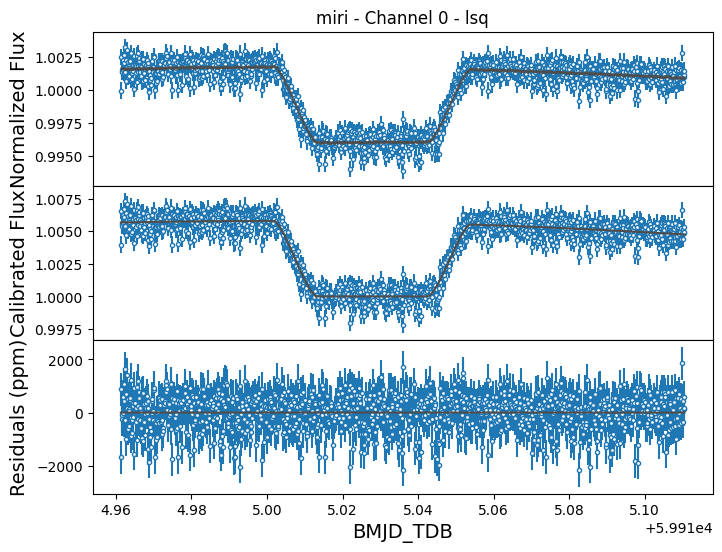

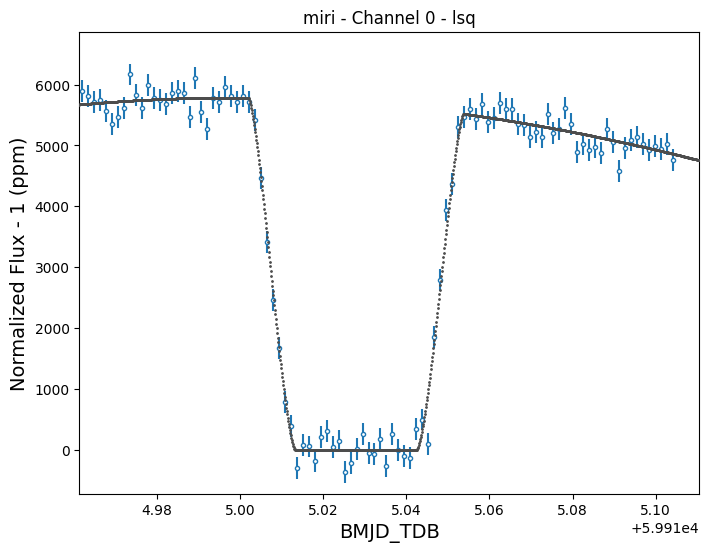

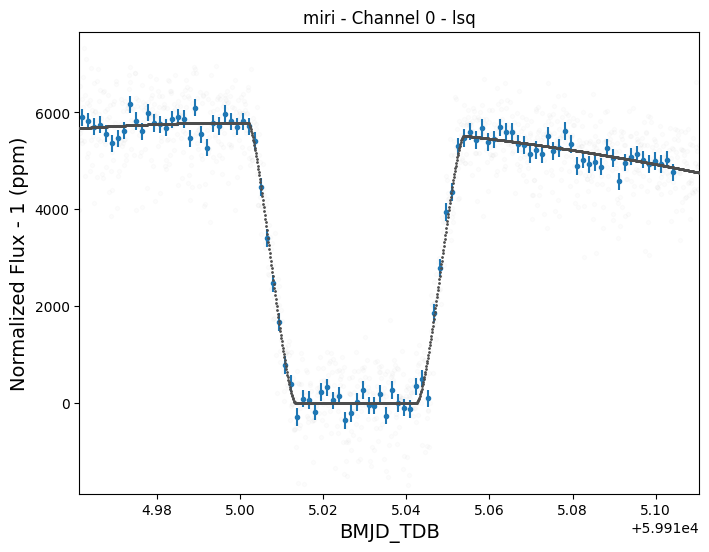

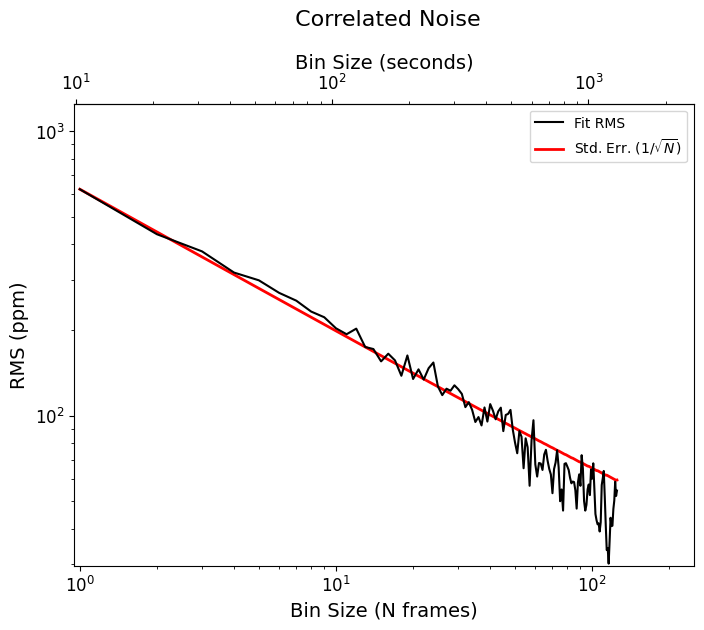

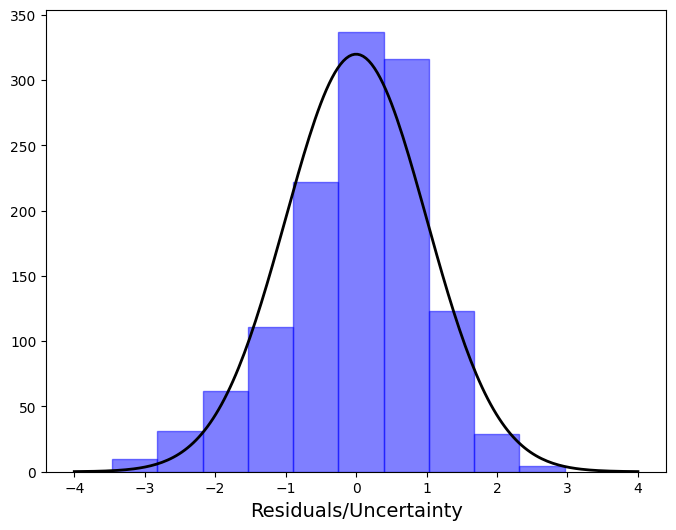

Completed lsq fit.
-------------------------


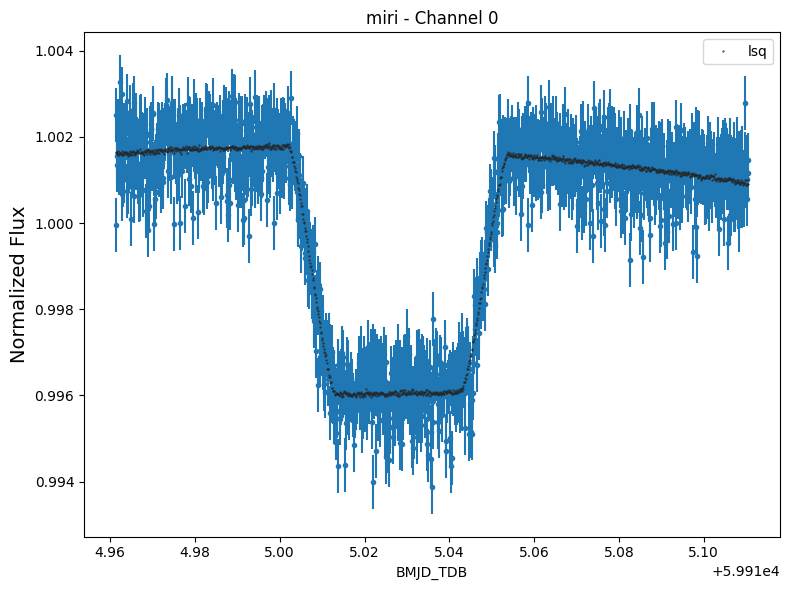

Saving results

Total time (min): 0.25


In [5]:
s5_meta = eureka.S5_lightcurve_fitting.s5_fit.fitlc(eventlabel)

# Sampling white lightcurve posterior

Estimating the confidence interval of our parameters $\theta$ could be done by extrapolating the posterior PDF from the MAP value using the first and second order gradient and then determining the extent to which each component of $\theta$ can be changed while still providing an adequately good fit to the observations. However, this technique can give inaccurate estimates especially in the presence of correlations between different parameters. Instead, a sampling algorithm like the Markov Chain Monte-Carlo (MCMC) method is typically used to estimate parameter uncertainties. Monte-Carlo (MC) methods in general involve randomly sampling values of $\theta$, while MCMCs are a specific variant where samples are randomly drawn based on the knowledge of the posterior probability from the previously drawn value; the draws of MCMC are typically called steps taken by a walker, and a collection of many walker steps are called a chain.

One increasingly popular sampling algorithm is called [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) which does not necessarily use a MCMC method. Nested sampling can be difficult to explain intuitively, but one of the nice advantages to nested sampling is that it can be used for model comparison. More relevant to our purposes here, the [dynesty](https://dynesty.readthedocs.io/en/stable/) dynamic nested sampling algorithm is able to quickly sample our posterior and has a convenient stopping condition which ensures the sampler has converged so that we get reliable uncertainties.

## Adjusting the Stage 5 "Eureka! Control File" (ECF)

Thankfully we can reuse the vast majority of our ECF settings above with only a few minor tweaks.

To begin, please first copy below the contents of the ECF that you filled out above. Then:

1. Change `fit_method` to be `[dynesty]` to instead use the dynesty sampler.
2. Add the following dynesty-related settings
  1. Set `run_nlive` to `121`. This sets the number of "live" points that dynesty will use (for more details see [here](https://dynesty.readthedocs.io/en/stable/faq.html#live-point-questions)). For reliable results, this must be greater than `ndim * (ndim + 1) // 2`, where `ndim` is the number of fitted parameters and `//` indicates integer division. In general, the larger this number the more robust your results will be and the longer they will take to run. A value of `121` is a fairly reasonable balance of speed and quality.
  2. Set `run_bound` to `'multi'`. This sets the type of bounds used by dynesty to "multiple ellipsoid decomposition". For more information, see [here](https://dynesty.readthedocs.io/en/stable/faq.html#bounding-questions). A value of `'multi'` should work for most problems.
  3. Set `run_sample` to `'auto'`. This lets dynesty choose the optimal sampling method based on the number of fitted parameters, and `auto` is a safe bet for most problems. For more information, see [here](https://dynesty.readthedocs.io/en/stable/faq.html#sampling-questions).
  4. Finally, set `run_tol` to `0.1`. This determines the stopping condition of the sampler. Smaller values will result in more precise posteriors at the cost of increased runtime, while larger values can result in poorly converged garbage. In general, a value of `0.1` should work for most problems.

In [6]:
s5_ecf_contents = f"""
# Eureka! Control File for Stage 5: Lightcurve Fitting

ncpu             1        # The number of CPU threads to use when running emcee, dynesty, or pymc3 in parallel

allapers         False    # Run S5 on all of the apertures considered in S4? Otherwise will use newest output in the inputdir
rescale_err      False    # Rescale uncertainties to have reduced chi-squared of unity
verbose          True     # If True, more details will be printed about steps

# NORMAL FITTING
fit_method       [dynesty]    # Which fitting methods do you want to use? This can be a list if you want to run multiple fitters (e.g. an optimizer and then a sampler that will start from the optimizer's final position).
run_myfuncs      [batman_ecl, sinusoid_pc, polynomial, ypos, ywidth]    # What functions do you want to fit?
fit_par          ./S5_fit_par_template.epf  # DO NOT CHANGE THIS LINE (it has been specially set for this workshop)

# Manual clipping in time
manual_clip      None    # A list of lists specifying the start and end integration numbers for manual removal.

# Force positive phase variations? (only used if sinusoid_pc is in run_myfuncs)
force_positivity True

# Limb darkening controls
# IMPORTANT: limb-darkening coefficients are not automatically fixed then, change to 'fixed' in .epf file whether they should be fixed or fitted!
use_generate_ld  None    # Use the generated limb-darkening coefficients from Stage 4? Options: exotic-ld, None. For exotic-ld, the limb-darkening laws available are linear, quadratic, 3-parameter and 4-parameter non-linear.
ld_file          None    # Fully qualified path to the location of a limb darkening file that you want to use
ld_file_white    None    # Fully qualified path to the location of a limb darkening file that you want to use for the white-light light curve (required if ld_file is not None and any EPF parameters are set to white_free or white_fixed).

# LSQ Settings
lsq_method       Powell  # Nelder-Mead
lsq_tol          1e-6
lsq_maxiter      None

# Dynesty Settings
run_nlive       121    # Must be > ndim * (ndim + 1) // 2
run_bound       'multi'
run_sample      'auto'
run_tol         0.1

# Plotting controls
interp           False   # Should astrophysical model be interpolated (useful for uneven sampling like that from HST)

# Diagnostics
isplots_S5       5       # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
nbin_plot        None    # The number of bins that should be used for figures 5104 and 5304. Defaults to 100.
testing_S5       False   # Boolean, set True to only use the first spectral channel
testing_model    False   # Boolean, set True to only inject a model source of systematics
hide_plots       False   # If True, plots will automatically be closed rather than popping up

# Project directory
topdir           /content/drive/MyDrive/SSW2023/MIRI

# Directories relative to project dir
inputdir         Stage4_white
outputdir        Stage5_white
"""

with open(f'S5_{eventlabel}.ecf', 'w') as f:
    f.write(s5_ecf_contents)

## Running Eureka!'s Stage 5

Because we want to use the exact same model and priors as our previous optimization run, there is no need to update our EPF and the code will just re-use the one we made above.

The following cell will run Eureka!'s Stage 5 using the settings you defined above. Note that your ECF and EPF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The following fit should take ~15 minutes to complete on Google Colab. While waiting for the fits to complete, you could begin setting up the next section.

"/content/drive/MyDrive/SSW2023/MIRI/Stage4_white/"
Using the metadata file: 
/content/drive/MyDrive/SSW2023/MIRI/Stage4_white/S4_2023-07-25_miri_run2/ap11_bg5/S4_miri_Meta_Save.dat
and will consider aperture ranges listed there. If this metadata file is not a part
of the run you intended, please provide a more precise folder for the metadata file.
Finished loading parameters from /content/drive/MyDrive/SSW2023/MIRI/Stage4_white/S4_2023-07-25_miri_run2/ap11_bg5//S4_miri_ap11_bg5_LCData.h5

Starting Stage 5: Light Curve Fitting

Input directory: /content/drive/MyDrive/SSW2023/MIRI/Stage4_white/S4_2023-07-25_miri_run2/ap11_bg5/
Output directory: /content/drive/MyDrive/SSW2023/MIRI/Stage5_white/S5_2023-07-25_miri_run2/ap11_bg5/
Copying S5 control file
Copying S5 parameter control file

Starting Channel 1 of 1

Starting dynesty fit.
Starting lnprob: -98761.40396441158
Running dynesty...


5924it [08:29, 11.63it/s, +121 | bound: 291 | nc: 1 | ncall: 179764 | eff(%):  3.365 | loglstar:   -inf < 7417.806 <    inf | logz: 7371.271 +/-    nan | dlogz:  0.001 >  0.100]


Summary
nlive: 121
niter: 5924
ncall: 179643
eff(%):  3.365
logz: 7371.271 +/-  0.677

Number of posterior samples is 6045


Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage5_white/S5_2023-07-25_miri_run2/ap11_bg5/S5_dynesty_samples_ch0.h5
Ending lnprob: 7444.435464803971
Reduced Chi-squared: 0.9988470051029725

DYNESTY RESULTS:
fp: 0.005706064350365385 (+5.337780424187564e-05, -5.367008919978343e-05)
AmpCos1: 0.4857825415153134 (+0.08461091506793217, -0.07836131001991742)
AmpSin1: -0.11811190291531981 (+0.09470656347546658, -0.07832257791047503)
per: 0.8134741005164102 (+2.204927507243326e-08, -2.254678477253691e-08)
t0: 55934.29223749816 (+4.0997379983309656e-05, -3.877793642459437e-05)
inc: 82.52989397503642 (+0.14089609067082165, -0.14343585725349328)
a: 4.907428600030119 (+0.041145050482701784, -0.038578782575364734)
c0: 0.9960644700027904 (+4.66226226415456e-05, -4.836524270457332e-05)
c1: 0.0015137055272785311 (+0.0033793266362906263, -0.003822953060894436)
ypos: 0.004086973587148112 (+0.0025786650141312005, -0.002842285984490816)
ywidth: 0.003446278789888303 (+0.0033006959276438456, -0.0

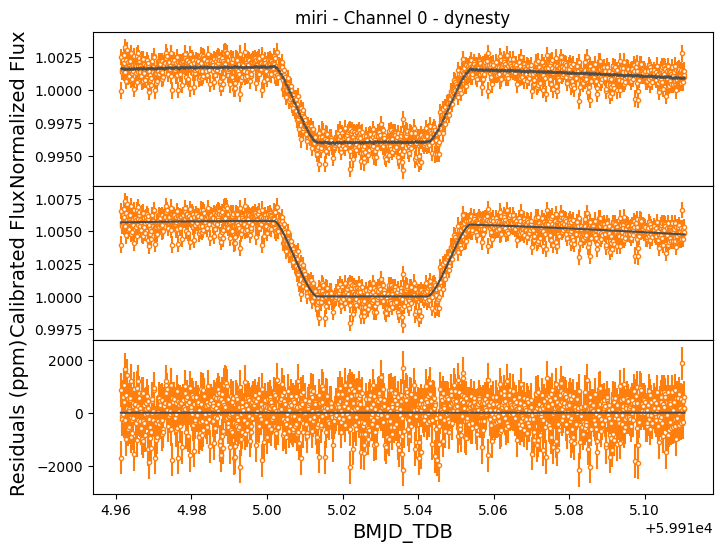

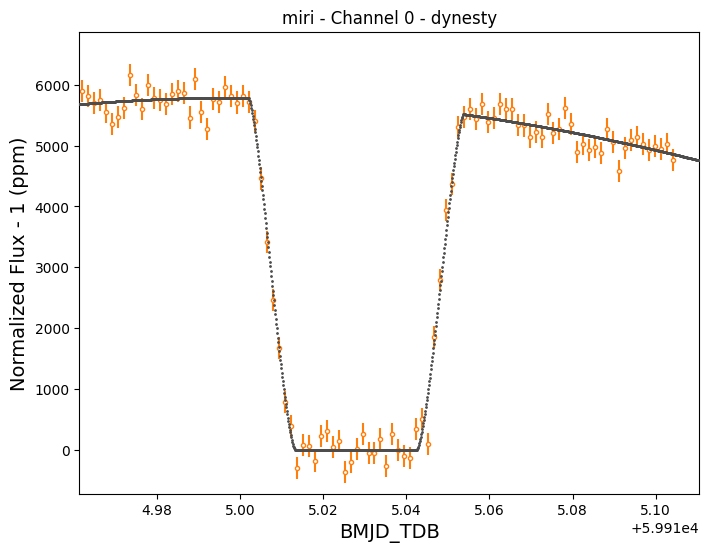

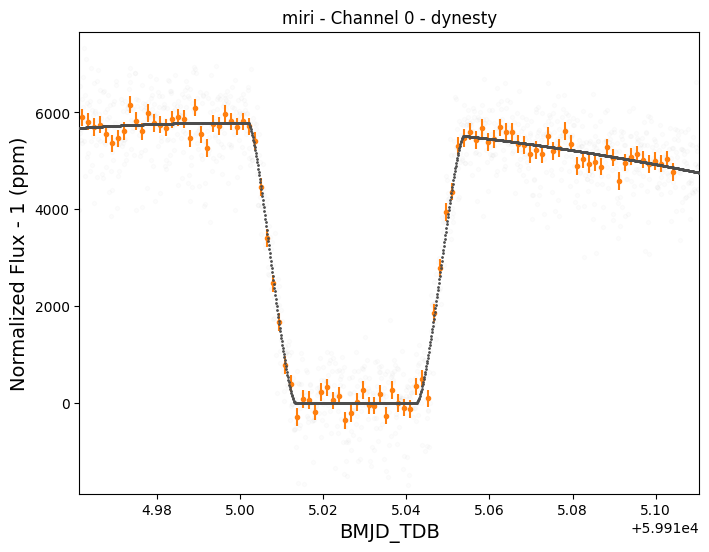

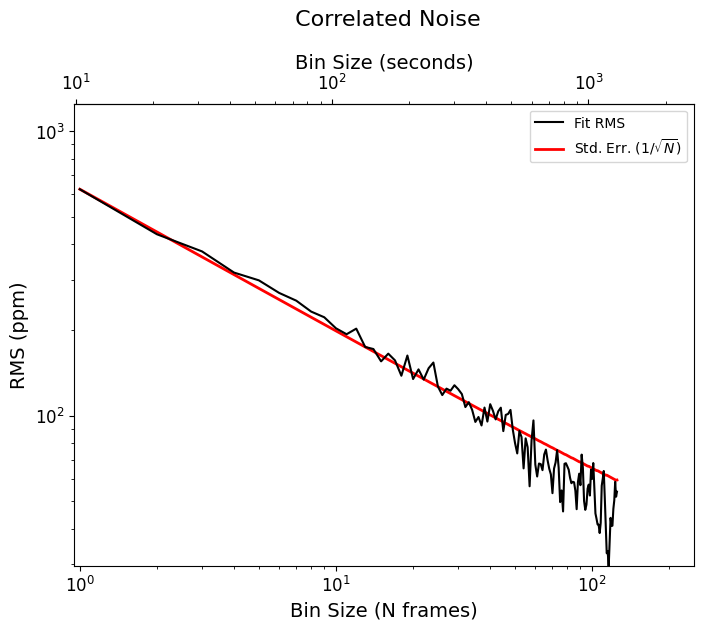

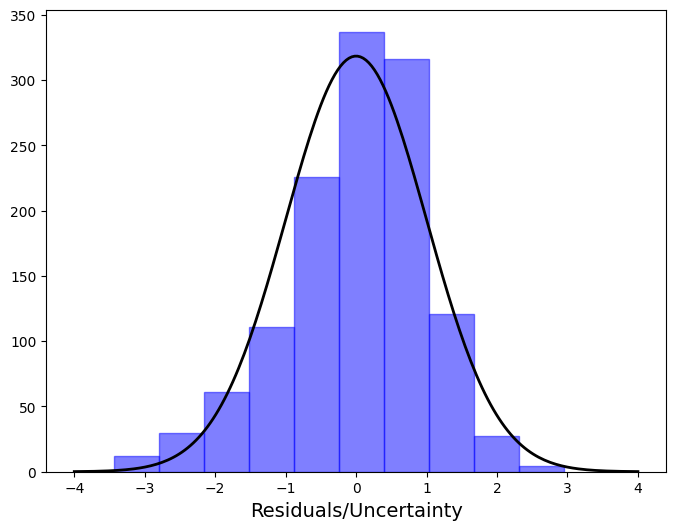

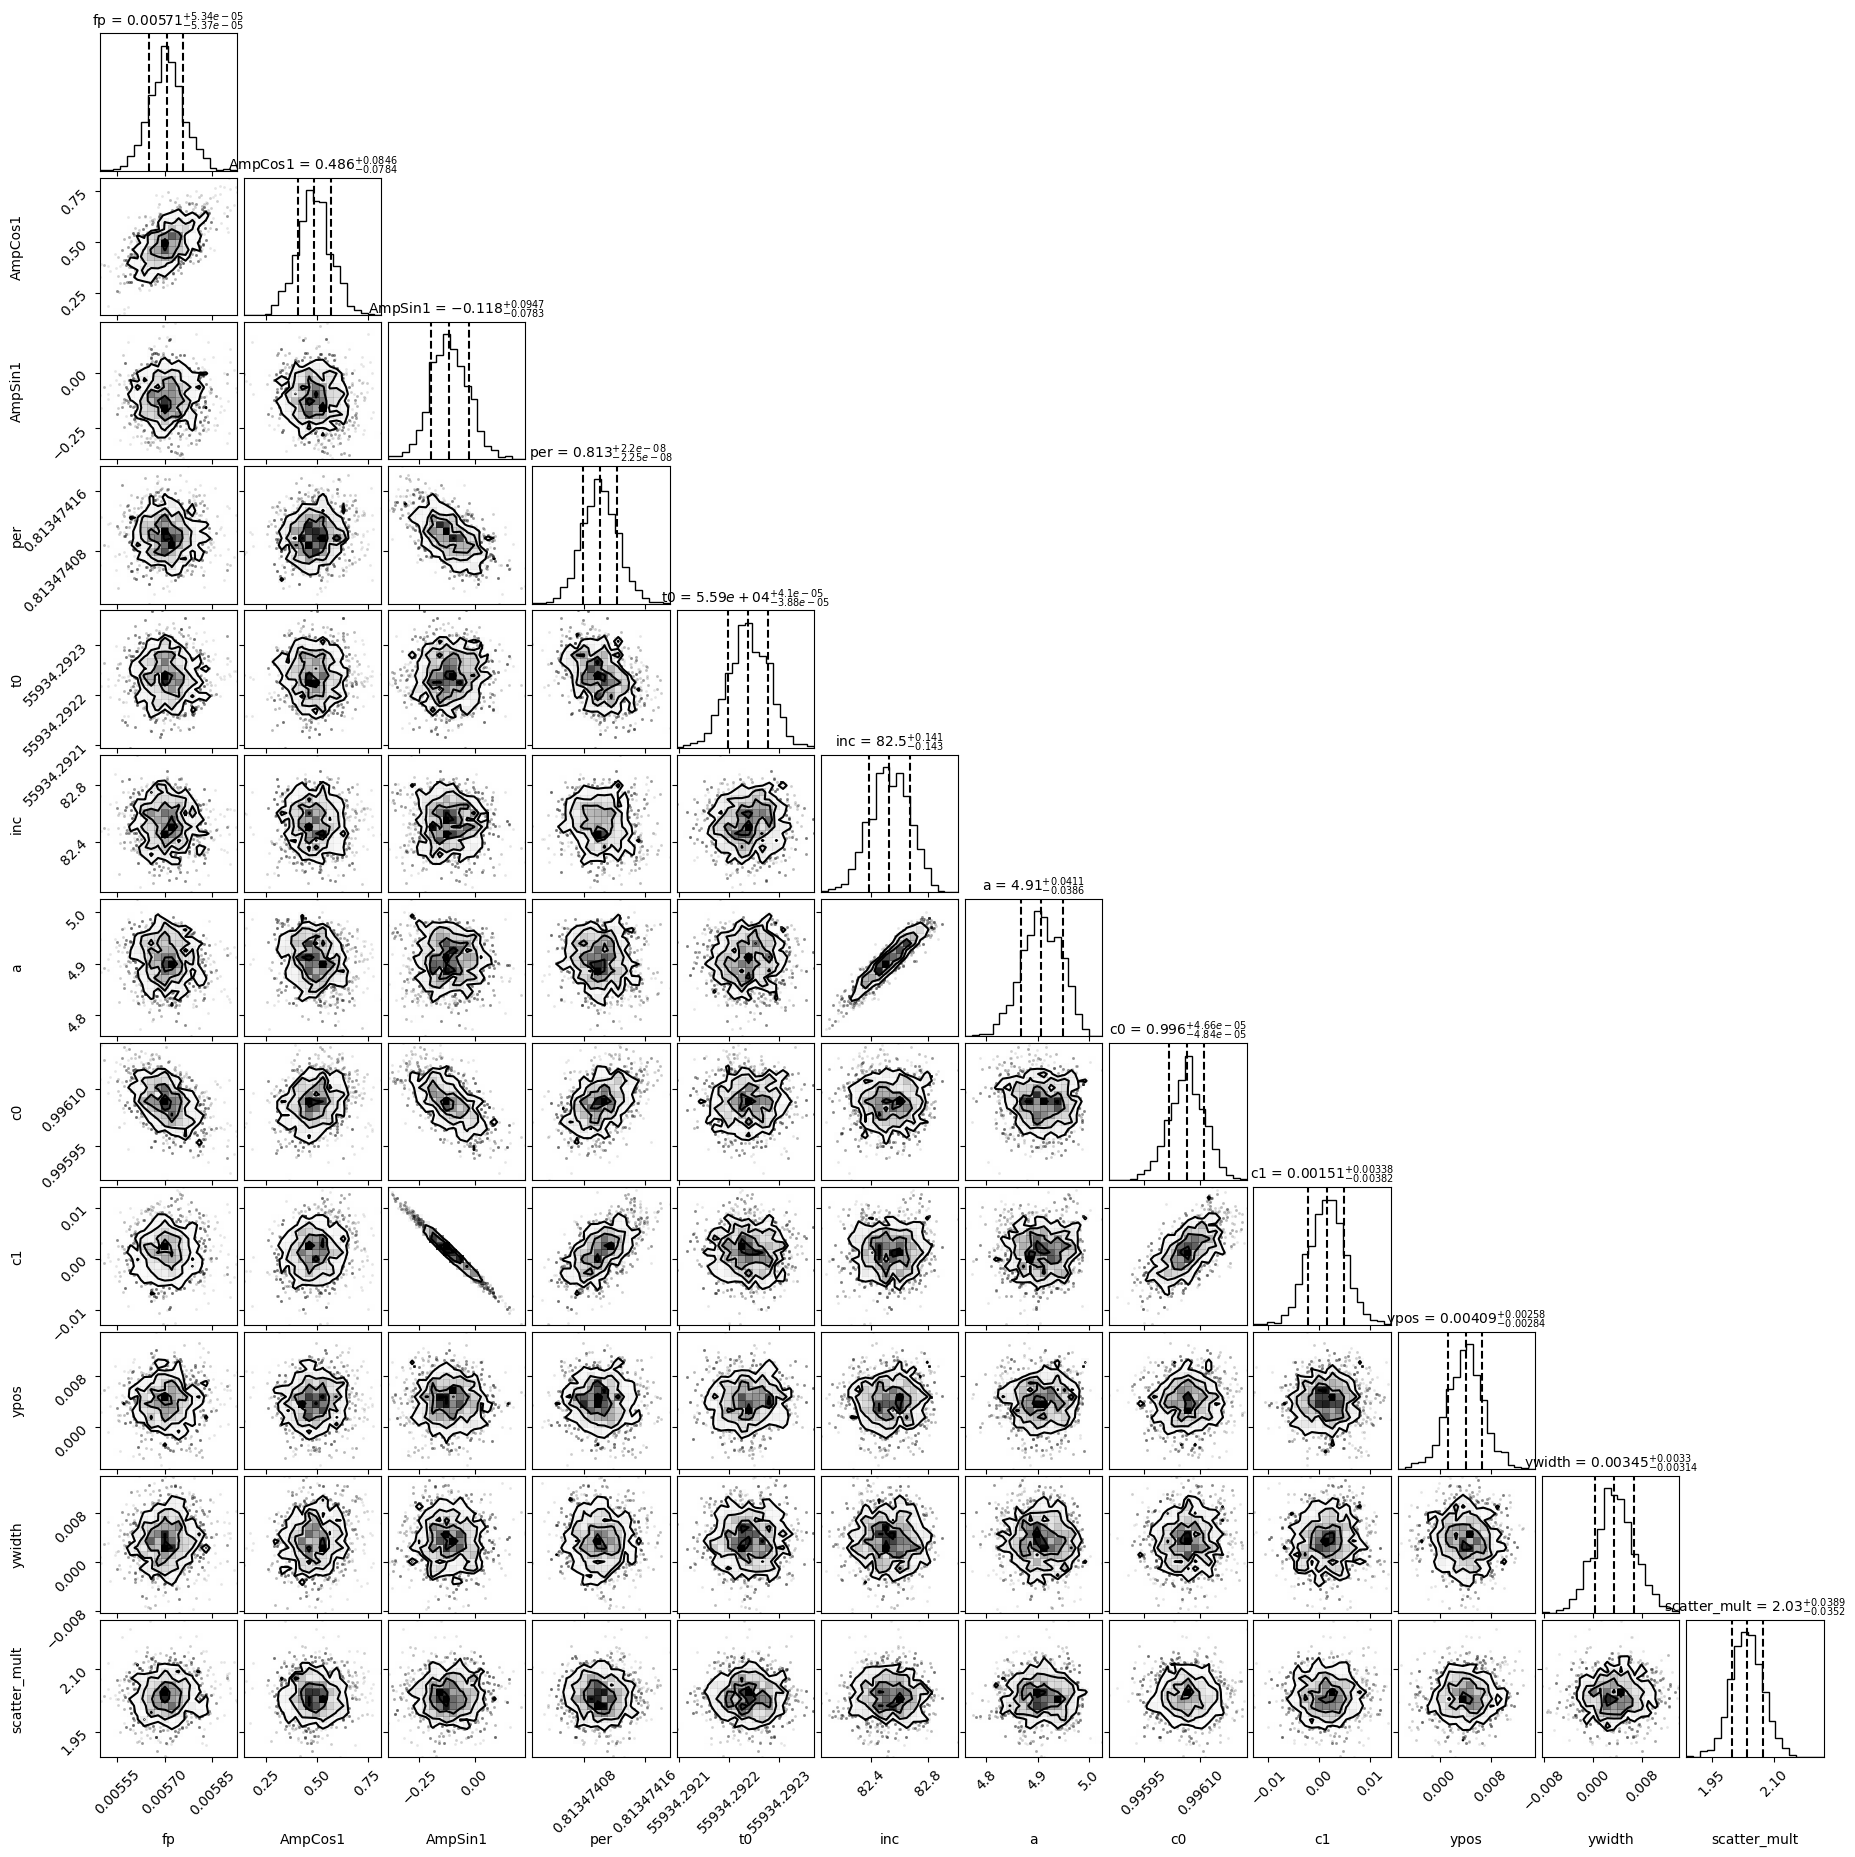

Completed dynesty fit.
-------------------------


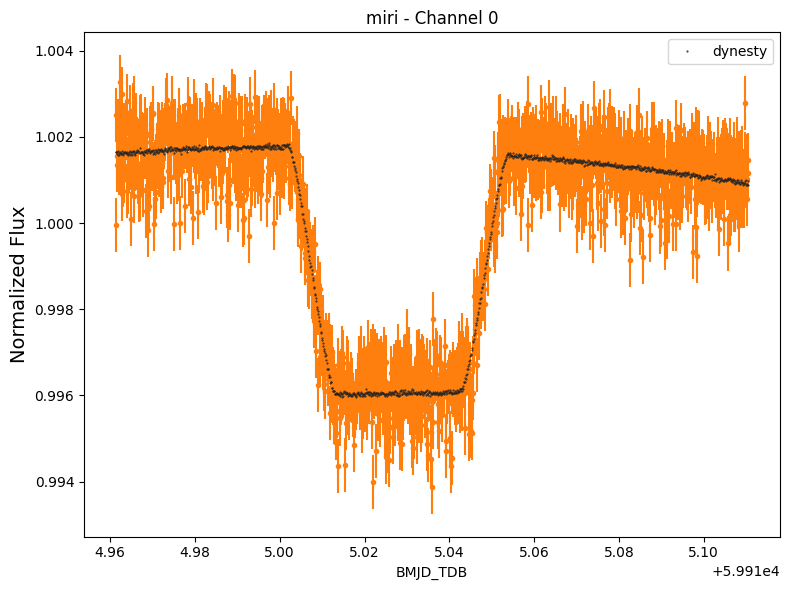

Saving results

Total time (min): 8.92


In [7]:
s5_meta = eureka.S5_lightcurve_fitting.s5_fit.fitlc(eventlabel)

# Optimizing fits to spectroscopic lightcurves

Now that we know how to find best-fit values and uncertainties from a single "white" lightcurve, it is easy to extrapolate those skills to perform fits to "spectroscopic" lightcurves to evaluate how parameters like the eclipse depth vary as a function of wavelength (which can tell us about molecules in the planets' atmospheres).

## Adjusting the Stage 5 "Eureka! Control File" (ECF)

Thankfully we can reuse the vast majority of our ECF settings above with only a few minor tweaks.

To begin, please first copy below the contents of the ECF that you filled out above. Then:

1. Change `fit_method` back to `[lsq]` to go back to using the optimization algorithm. Running dynesty on each channel will take too long to be completed during this workshop but could be an interesting exercise on your own.
2. Since we're now fitting spectroscopic lightcurves, we'll adjust the `inputdir` to `Stage4/S4_2023-06-02_miri_run1` and the `outputdir` to `Stage5`. This `inputdir` setting will use our provided Stage 4 output files, but if you want to try using your own results from Workshop #1, you can instead set `intputdir` to `Stage4` to use your most recent Stage4 result or you can choose a specific run using the syntax `Stage4/S4_YYYY-MM-DD_miri_runN` where YYYY is the year (e.g., `2023`), MM is the month (e.g., `07`), DD is the day (e.g., `24`), and N is the particular run number that you want to use (e.g., `1`).

And that's it for adjustments to the ECF!

In [8]:
s5_ecf_contents = f"""
# Eureka! Control File for Stage 5: Lightcurve Fitting

ncpu             1        # The number of CPU threads to use when running emcee, dynesty, or pymc3 in parallel

allapers         False    # Run S5 on all of the apertures considered in S4? Otherwise will use newest output in the inputdir
rescale_err      False    # Rescale uncertainties to have reduced chi-squared of unity
verbose          True     # If True, more details will be printed about steps

# NORMAL FITTING
fit_method       [lsq]    # Which fitting methods do you want to use? This can be a list if you want to run multiple fitters (e.g. an optimizer and then a sampler that will start from the optimizer's final position).
run_myfuncs      [batman_ecl, sinusoid_pc, polynomial, ypos, ywidth]    # What functions do you want to fit?
fit_par          ./S5_fit_par_template.epf  # DO NOT CHANGE THIS LINE (it has been specially set for this workshop)

# Manual clipping in time
manual_clip      None    # A list of lists specifying the start and end integration numbers for manual removal.

# Force positive phase variations? (only used if sinusoid_pc is in run_myfuncs)
force_positivity True

# Limb darkening controls
# IMPORTANT: limb-darkening coefficients are not automatically fixed then, change to 'fixed' in .epf file whether they should be fixed or fitted!
use_generate_ld  None    # Use the generated limb-darkening coefficients from Stage 4? Options: exotic-ld, None. For exotic-ld, the limb-darkening laws available are linear, quadratic, 3-parameter and 4-parameter non-linear.
ld_file          None    # Fully qualified path to the location of a limb darkening file that you want to use
ld_file_white    None    # Fully qualified path to the location of a limb darkening file that you want to use for the white-light light curve (required if ld_file is not None and any EPF parameters are set to white_free or white_fixed).

# LSQ Settings
lsq_method       Powell  # Nelder-Mead
lsq_tol          1e-6
lsq_maxiter      None

# Dynesty Settings
run_nlive       121    # Must be > ndim * (ndim + 1) // 2
run_bound       'multi'
run_sample      'auto'
run_tol         0.1

# Plotting controls
interp           False   # Should astrophysical model be interpolated (useful for uneven sampling like that from HST)

# Diagnostics
isplots_S5       5       # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
nbin_plot        None    # The number of bins that should be used for figures 5104 and 5304. Defaults to 100.
testing_S5       False   # Boolean, set True to only use the first spectral channel
testing_model    False   # Boolean, set True to only inject a model source of systematics
hide_plots       False   # If True, plots will automatically be closed rather than popping up

# Project directory
topdir           /content/drive/MyDrive/SSW2023/MIRI

# Directories relative to project dir
inputdir         Stage4
outputdir        Stage5
"""

with open(f'S5_{eventlabel}.ecf', 'w') as f:
    f.write(s5_ecf_contents)

## Adjusting the Stage 5 "Eureka! Parameter File" (EPF)

Thankfully we can reuse the vast majority of our EPF settings above with only a few minor tweaks.

To begin, please first copy below the contents of the EPF that you filled out above. Then you just need to set any parameters that cannot vary with wavelength to be `'fixed'`. The relevant parameters that cannot vary with wavelength are the orbital parameters which are `per`, `t0`, `a`, and `inc`.

One option is to fix these parameters to the best-fit values obtained from your optimization run near the top of the notebook. Alternatively, you could also fix them to the published values from Bonomo et al. 2017. If you go with the former, copy-paste your best-fit values for `per`, `t0`, `a`, and `inc` into the `Value` column and set the `Free?` column to `'fixed'`. If you go with the latter option, you just need to set the `Free?` column to `'fixed'`.

In [9]:
s5_epf_contents = f"""
# Name      Value           Free?			    PriorPar1      PriorPar2  PriorType
#-------------------------------------------------------------------------------------------------------
# Astrophysical priors from Bonomo et al. 2017
# ------------------
# ** Transit/eclipse parameters **
# ------------------
rp          0.15738       'fixed'  # Fixing this to the approximate value I got from the full phasecurve
fp          6000e-6       'free'        6000e-6         5000e-6    N
# ----------------------
# ** Phase curve parameters **
# ----------------------
AmpCos1     0             'free'        -1              1          U  # Marginalizing over the possible phase variations
AmpSin1     0.            'free'        -1              1          U  # Marginalizing over the possible phase variations
# ------------------
# Orbital parameters
# ------------------
per         0.81347409255 'fixed'
t0          55934.2922336 'fixed'
time_offset 0             'independent'
inc         82.5634159347 'fixed'
a           4.93716858131 'fixed'
ecc         0             'fixed'
w           90            'fixed'
# --------------------
# Systematic variables
# --------------------
c0          1.0           'free'        1.0             0.001      N
c1          0             'free'        0               0.01       N
# Centroid decorrelation parameters
ypos        0             'free'        0.              0.1        N
ywidth      0             'free'        0.              10         N
# -----------
# White noise
# -----------
scatter_mult 1.1          'free'        1.1             2          N
# ---------------------------------------
# Light travel time correction parameters
# ---------------------------------------
Rs          0.667         'fixed'
"""

with open('S5_fit_par_template.epf', 'w') as f:
    f.write(s5_epf_contents)

## Running Eureka!'s Stage 5

The following cell will run Eureka!'s Stage 5 using the settings you defined above. Note that your ECF and EPF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The code will loop through each wavelength channel, printing information about the fit and showing plots as it goes.

The following fits should take a total of ~4 minutes to complete on Google Colab. While waiting for the fits to complete, you could begin setting up the next section.

"/content/drive/MyDrive/SSW2023/MIRI/Stage4/"
Using the metadata file: 
/content/drive/MyDrive/SSW2023/MIRI/Stage4/S4_2023-07-25_miri_run2/ap11_bg5/S4_miri_Meta_Save.dat
and will consider aperture ranges listed there. If this metadata file is not a part
of the run you intended, please provide a more precise folder for the metadata file.
Finished loading parameters from /content/drive/MyDrive/SSW2023/MIRI/Stage4/S4_2023-07-25_miri_run2/ap11_bg5//S4_miri_ap11_bg5_LCData.h5

Starting Stage 5: Light Curve Fitting

Input directory: /content/drive/MyDrive/SSW2023/MIRI/Stage4/S4_2023-07-25_miri_run2/ap11_bg5/
Output directory: /content/drive/MyDrive/SSW2023/MIRI/Stage5/S5_2023-07-25_miri_run1/ap11_bg5/
Copying S5 control file
Copying S5 parameter control file

Starting Channel 1 of 11

Starting lsq fit.
Starting lnprob: -20455.460283449283


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Current lnprob =  5404.711311441537
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -5404.711311441537
       x: [ 4.274e-03 -5.186e-01 -9.077e-02  9.968e-01  2.364e-03
            7.736e-03  1.374e-03  4.330e+00]
     nit: 11
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 9.854e-05  3.146e-01 ...  4.179e-04 -9.674e-03]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-5.831e-05 -9.756e-02 ... -8.395e-05 -4.822e-03]]
    nfev: 1059

Ending lnprob: 5404.711311441537
Reduced Chi-squared: 1.010121112166185

LSQ RESULTS:
fp: 0.004274239550002579
AmpCos1: -0.5186370293909178
AmpSin1: -0.09076779545272311
c0: 0.9968261509117324
c1: 0.002364317485605864
ypos: 0.007735912709807765
ywidth: 0.0013743728835154362
scatter_mult: 4.330184517530612; 3188.5490857854247 ppm



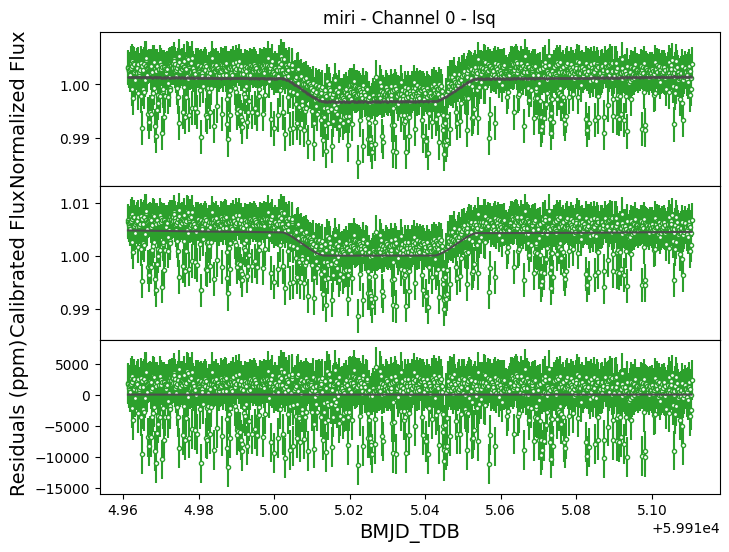

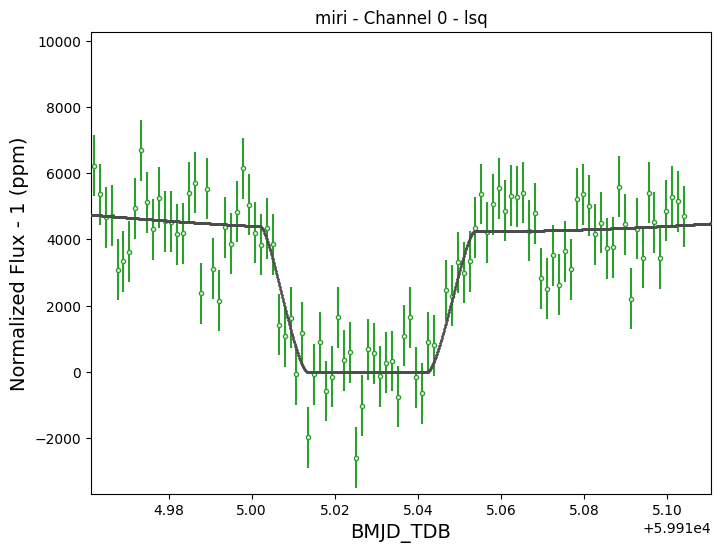

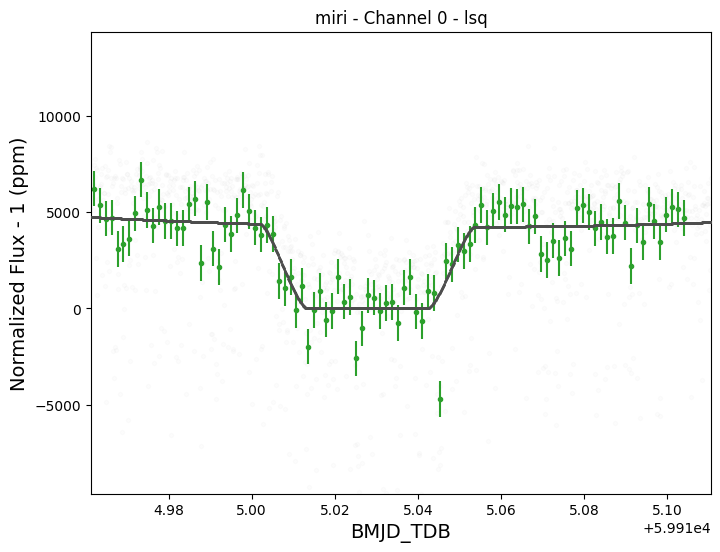

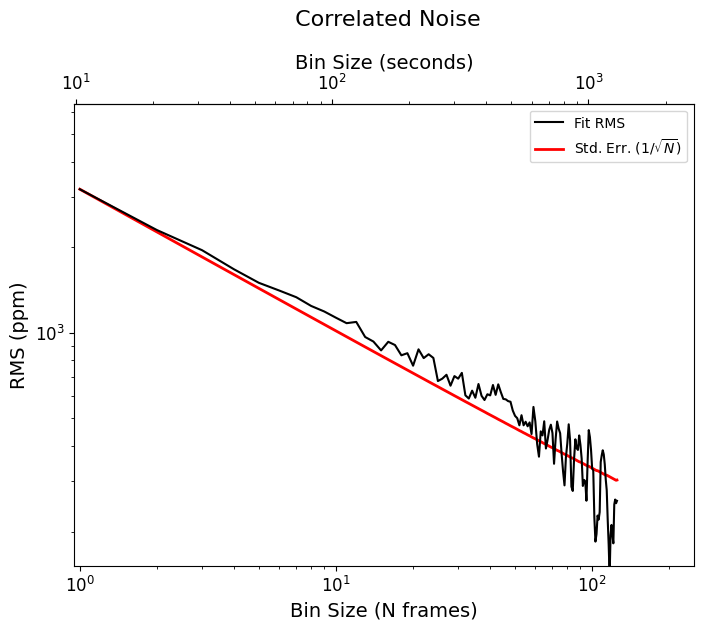

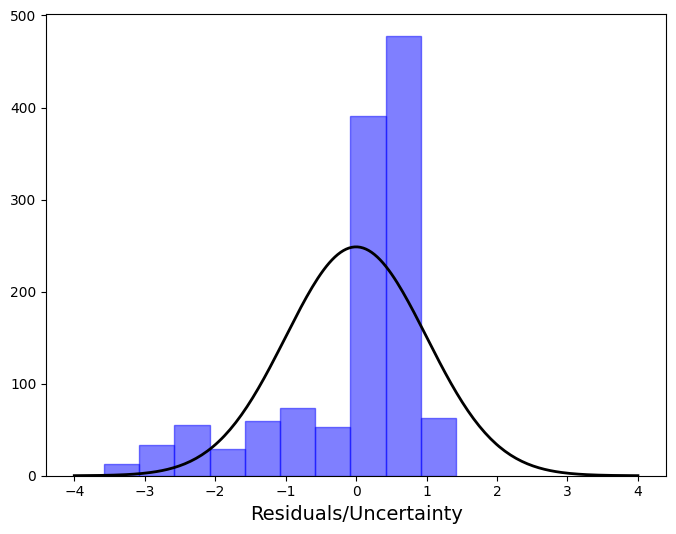

Completed lsq fit.
-------------------------


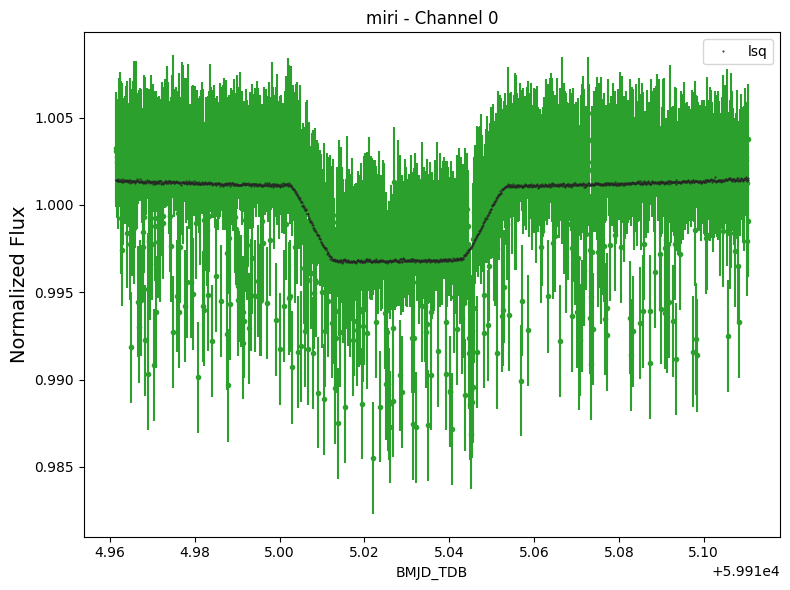

Saving results

Starting Channel 2 of 11

Starting lsq fit.
Starting lnprob: 5882.0794724467905

Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6946.330737656974
       x: [ 5.080e-03  2.358e-01  6.254e-02  9.964e-01 -7.536e-03
            5.545e-03  3.677e-03  1.167e+00]
     nit: 10
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [-1.009e-05  3.344e-02 ...  6.733e-05 -4.473e-03]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-8.886e-06 -6.097e-02 ... -1.058e-06  1.344e-04]]
    nfev: 886

Ending lnprob: 6946.330737656974
Reduced Chi-squared: 1.0062463052230488

LSQ RESULTS:
fp: 0.00508039488511665
AmpCos1: 0.23575281872653073
AmpSin1: 0.06254156389677575
c0: 0.9963591617510925
c1: -0.007535783719156769
ypos: 0.005545397277371958
ywidth: 0.003677145530542782
scatter_mult: 1.1666896536488933; 928.8616223158508 ppm



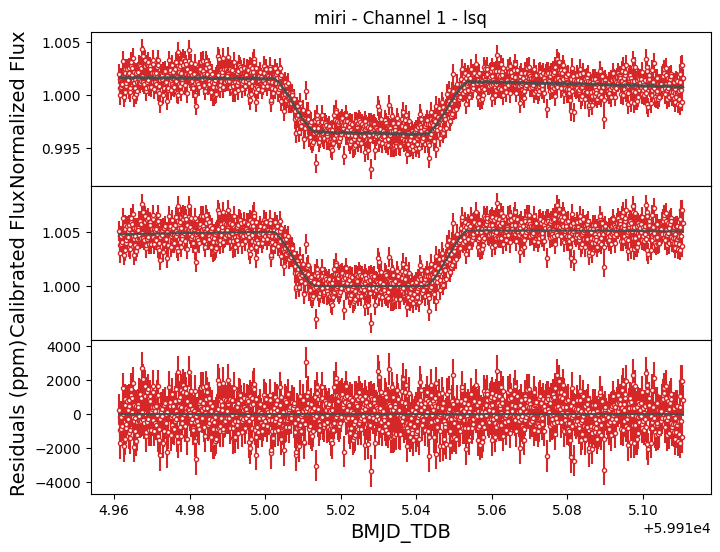

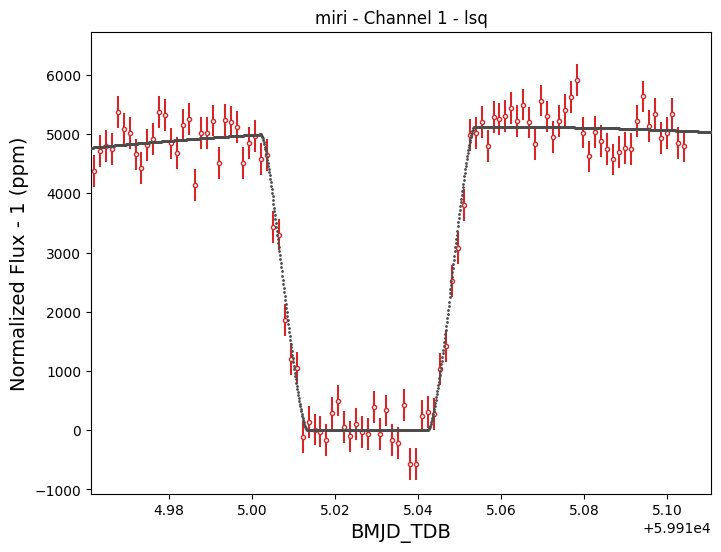

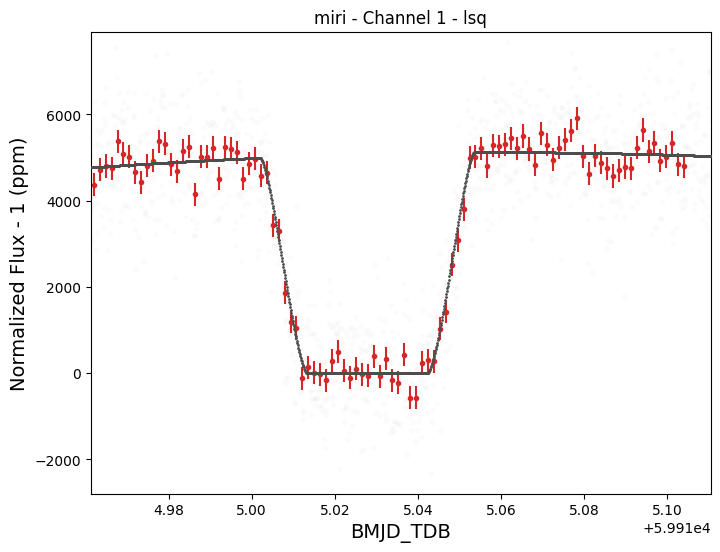

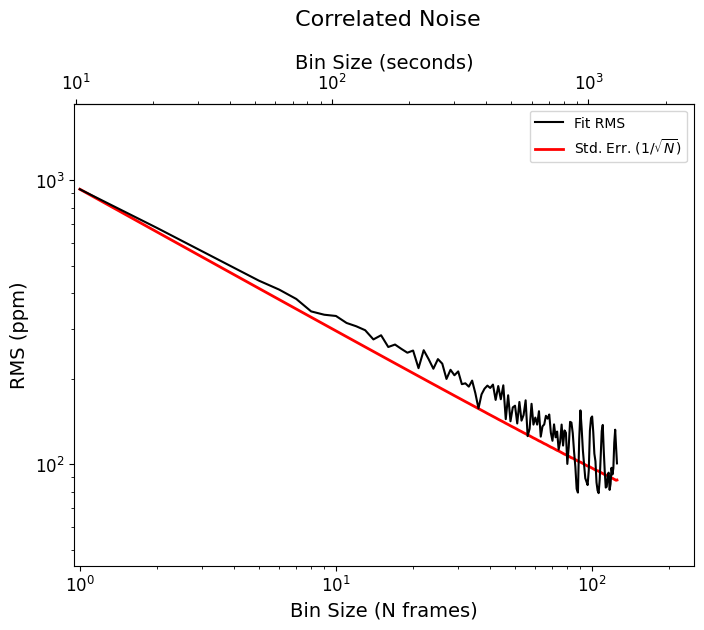

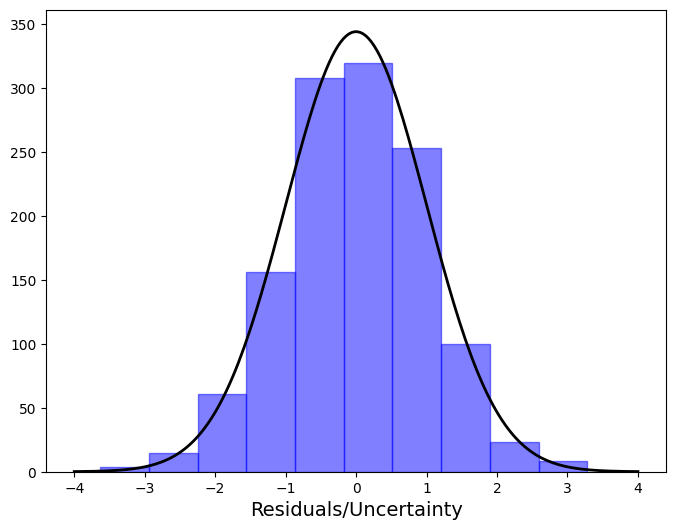

Completed lsq fit.
-------------------------


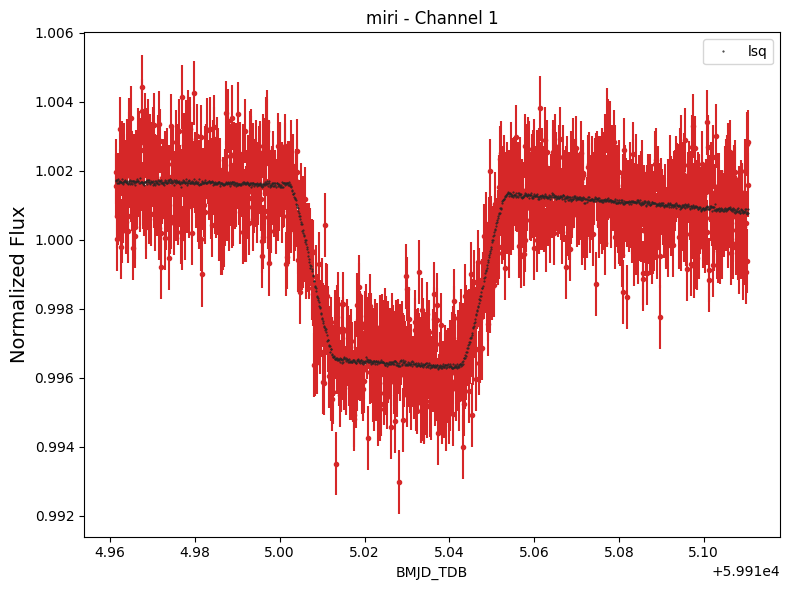

Saving results

Starting Channel 3 of 11

Starting lsq fit.
Starting lnprob: 6856.542074303828
Current lnprob =  6882.447118682791
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6883.4716810052105
       x: [ 5.516e-03  6.846e-01  8.690e-02  9.962e-01 -6.201e-03
            1.189e-02  7.632e-04  1.259e+00]
     nit: 5
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 1.755e-04  3.346e-01 ...  4.943e-04 -7.677e-03]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 8.179e-05 -3.766e-02 ... -7.717e-05 -2.991e-03]]
    nfev: 406

Ending lnprob: 6883.4716810052105
Reduced Chi-squared: 1.0066492815425647

LSQ RESULTS:
fp: 0.005515758018558682
AmpCos1: 0.6846025129500116
AmpSin1: 0.086901734490583
c0: 0.9961765163708554
c1: -0.006200985724719357
ypos: 0.011886920499417069
ywidth: 0.0007631515519034911
scatter_mult: 1.2591514671581505; 976.2034402685453 ppm



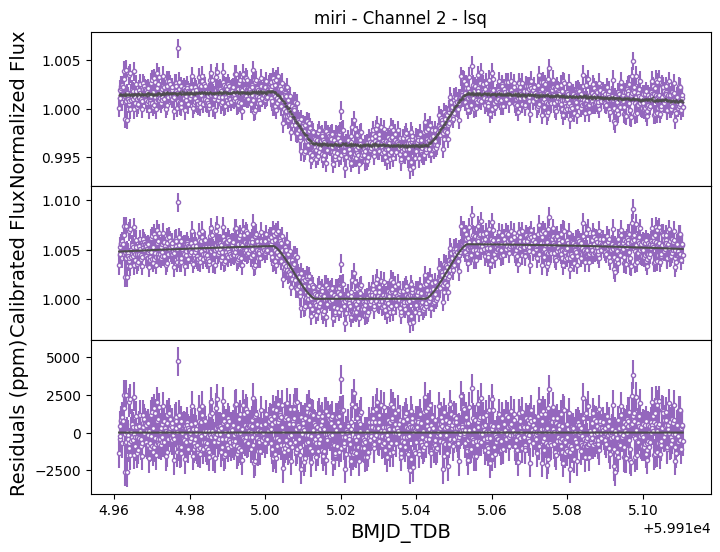

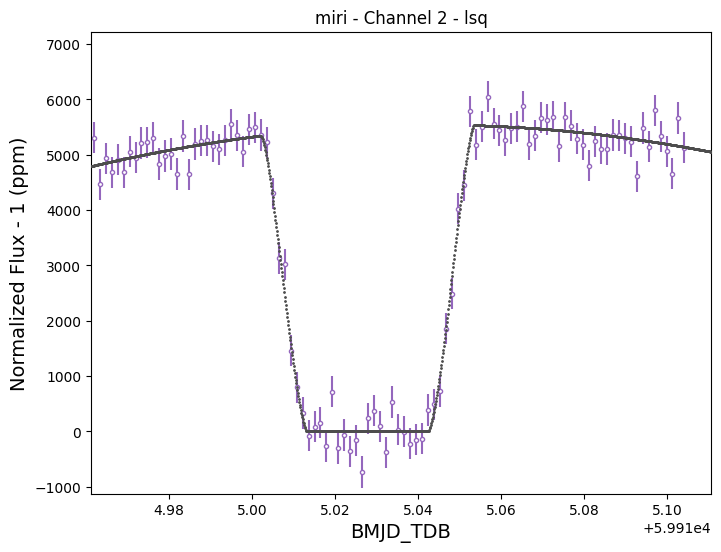

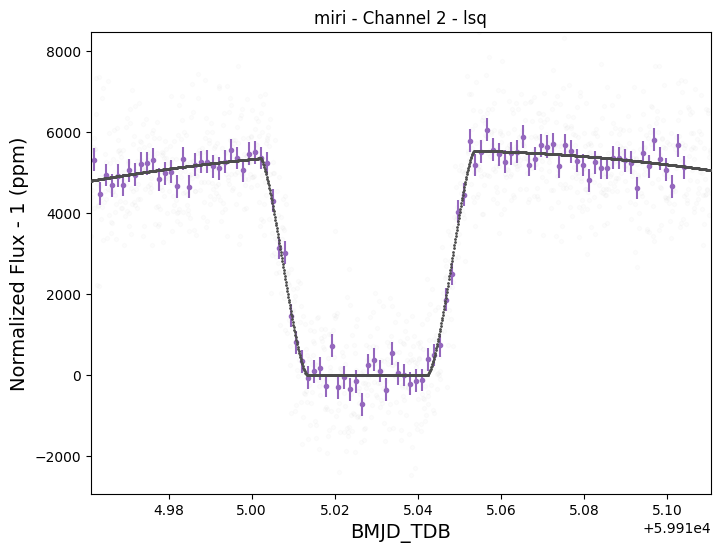

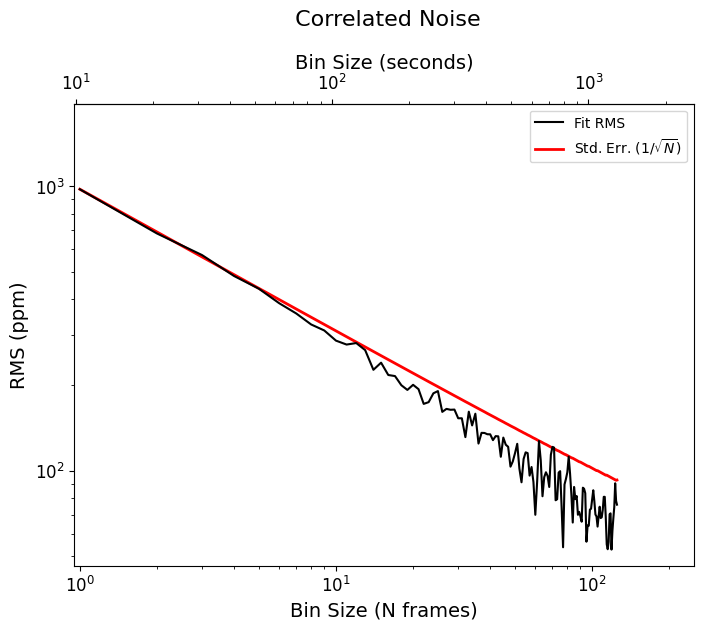

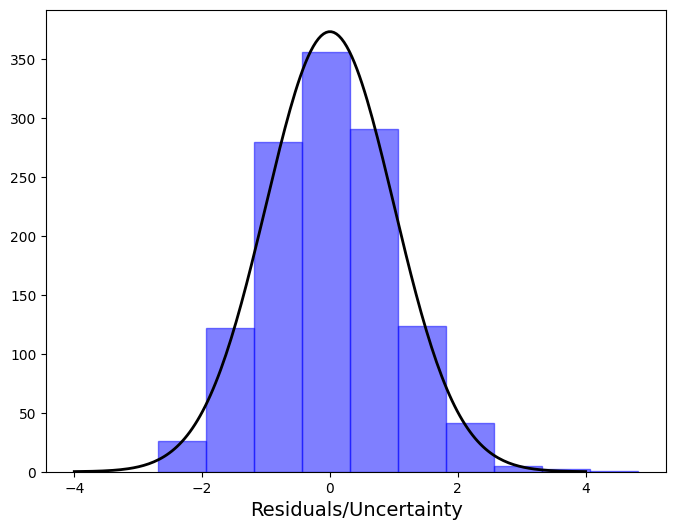

Completed lsq fit.
-------------------------


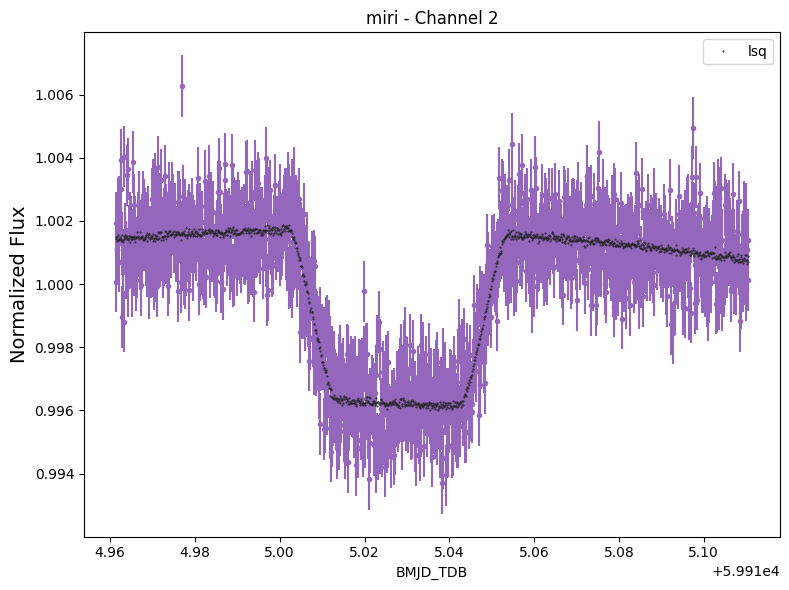

Saving results

Starting Channel 4 of 11

Starting lsq fit.
Starting lnprob: 6720.185702422749
Current lnprob =  6733.085468515166
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6733.106821846733
       x: [ 5.152e-03  5.566e-01  5.821e-02  9.964e-01 -6.631e-03
            7.509e-03 -7.755e-03  1.275e+00]
     nit: 5
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [-2.279e-04 -1.442e-01 ... -3.348e-04 -6.082e-03]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 4.653e-06  2.551e-02 ...  5.175e-05  2.745e-04]]
    nfev: 401

Ending lnprob: 6733.106821846733
Reduced Chi-squared: 1.0056749551167607

LSQ RESULTS:
fp: 0.005151727383233393
AmpCos1: 0.5565599469108538
AmpSin1: 0.05820990341044337
c0: 0.9964016970410485
c1: -0.0066305810604815035
ypos: 0.007509461068712261
ywidth: -0.007754699488617436
scatter_mult: 1.2745226459269579; 1097.1147259598292 ppm



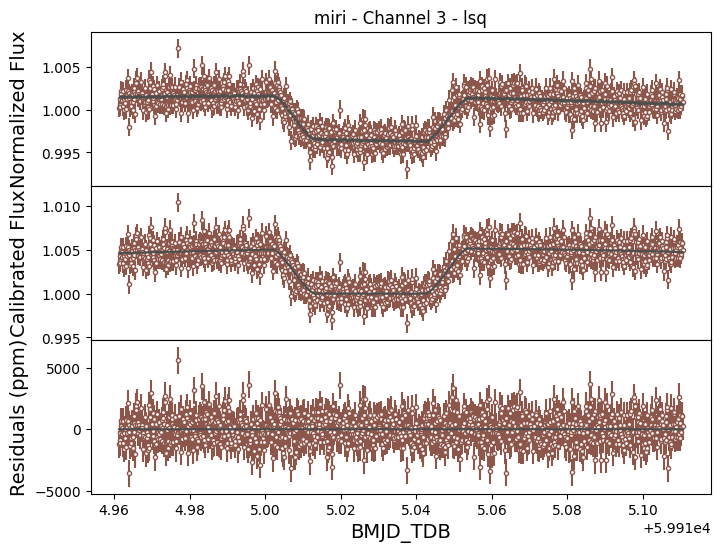

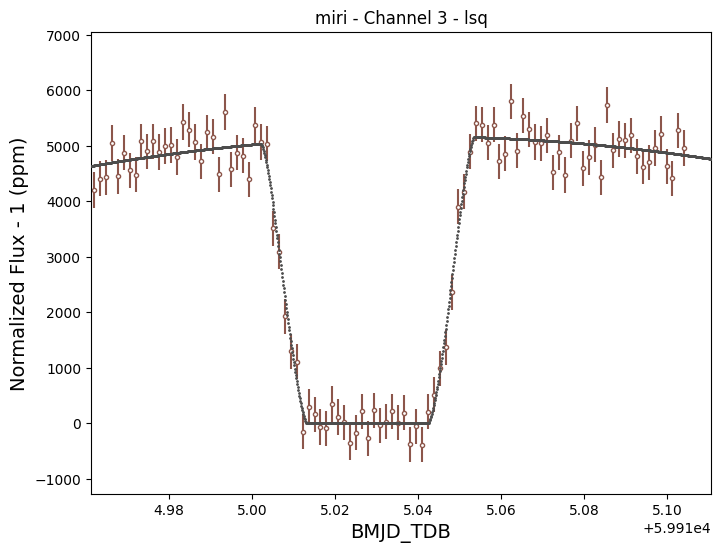

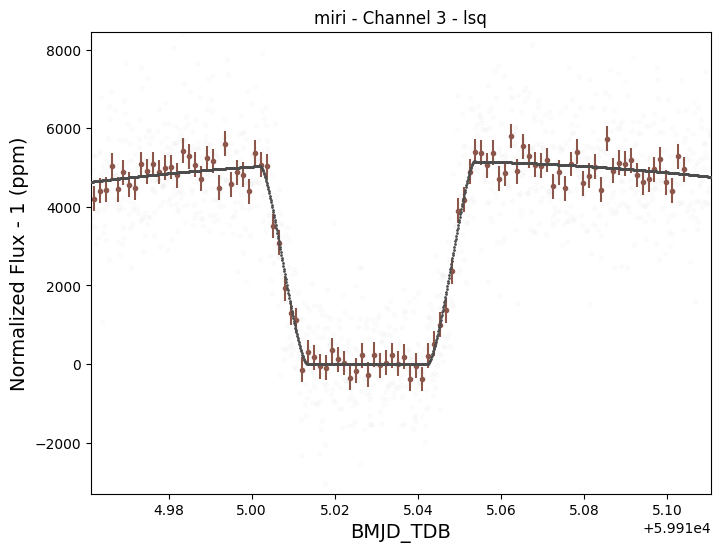

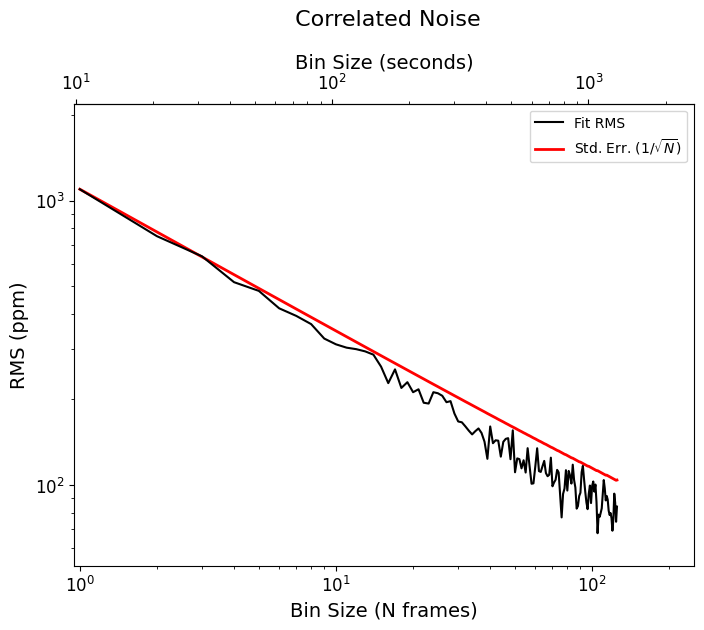

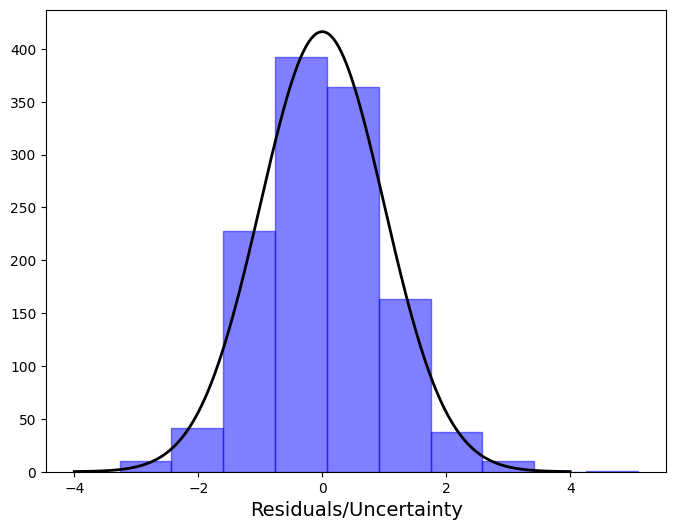

Completed lsq fit.
-------------------------


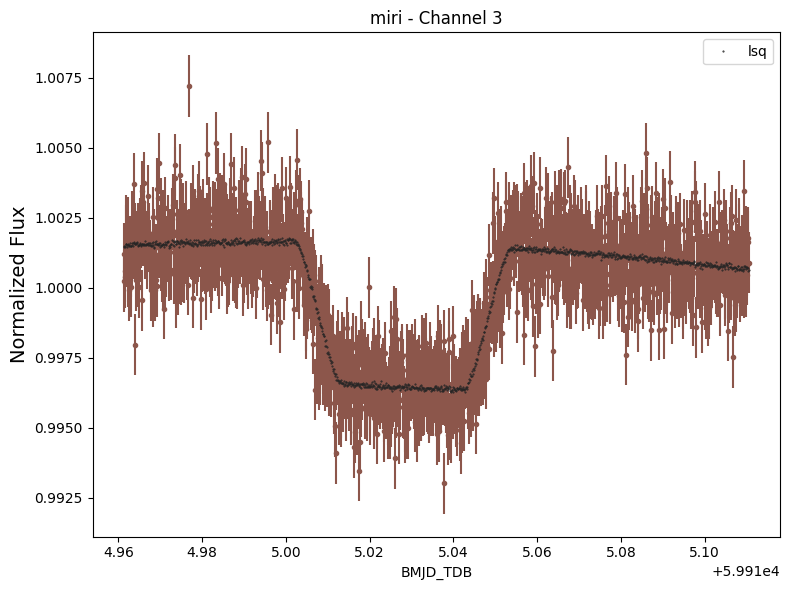

Saving results

Starting Channel 5 of 11

Starting lsq fit.
Starting lnprob: 6587.966908902356

Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6610.554024929615
       x: [ 5.748e-03  7.718e-01 -1.856e-01  9.961e-01  4.150e-03
            7.066e-03  4.861e-03  1.290e+00]
     nit: 10
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 3.062e-05 -1.284e-02 ... -6.595e-05 -3.268e-03]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-3.509e-05 -4.115e-03 ... -2.762e-05 -6.479e-04]]
    nfev: 853

Ending lnprob: 6610.554024929615
Reduced Chi-squared: 1.0064249603653683

LSQ RESULTS:
fp: 0.005748482005363313
AmpCos1: 0.7717816064478829
AmpSin1: -0.1856245259748123
c0: 0.9961369395782509
c1: 0.004149558650112354
ypos: 0.0070661844685780155
ywidth: 0.004860914826659048
scatter_mult: 1.2896072641514897; 1214.7565023680343 ppm



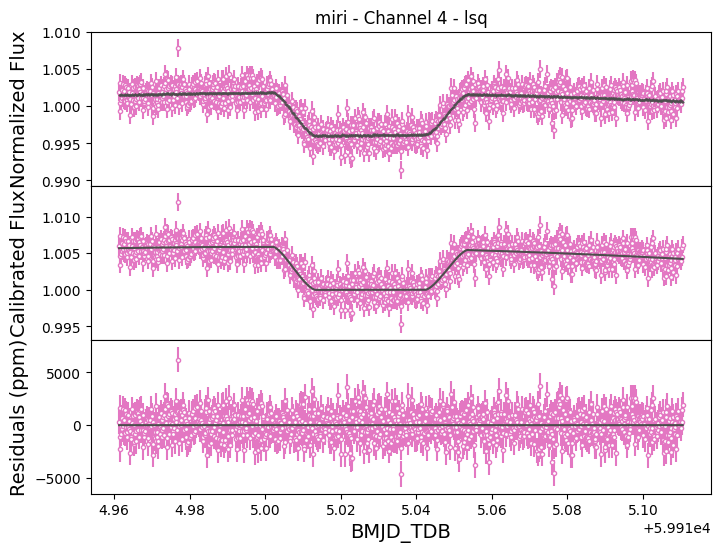

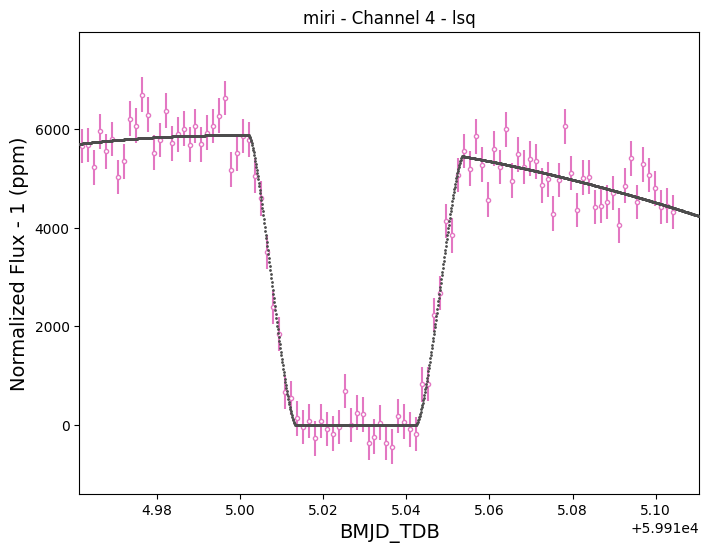

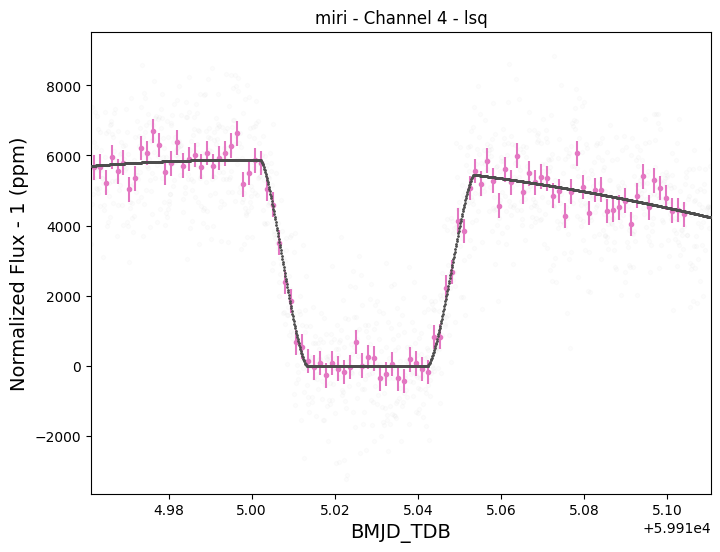

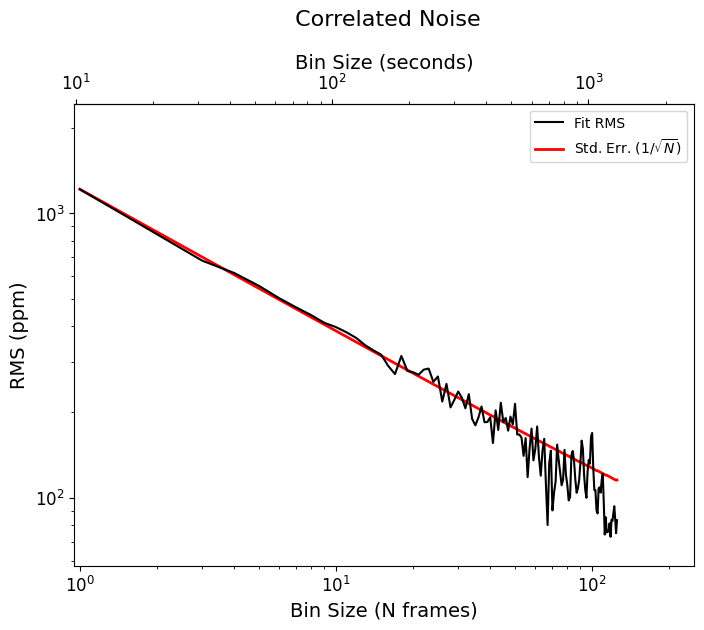

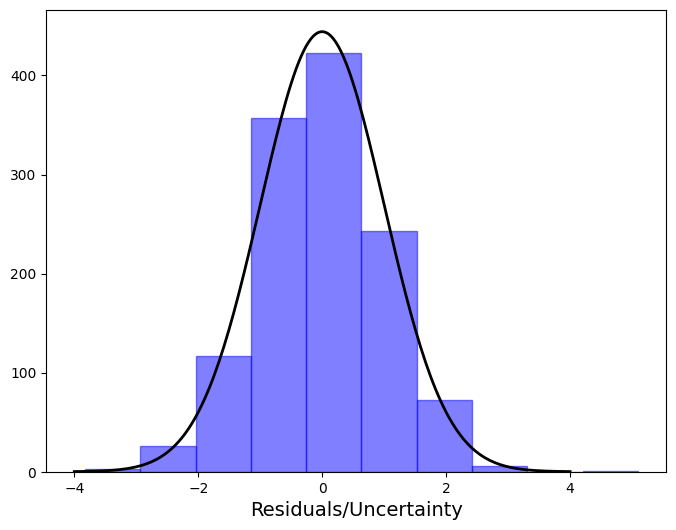

Completed lsq fit.
-------------------------


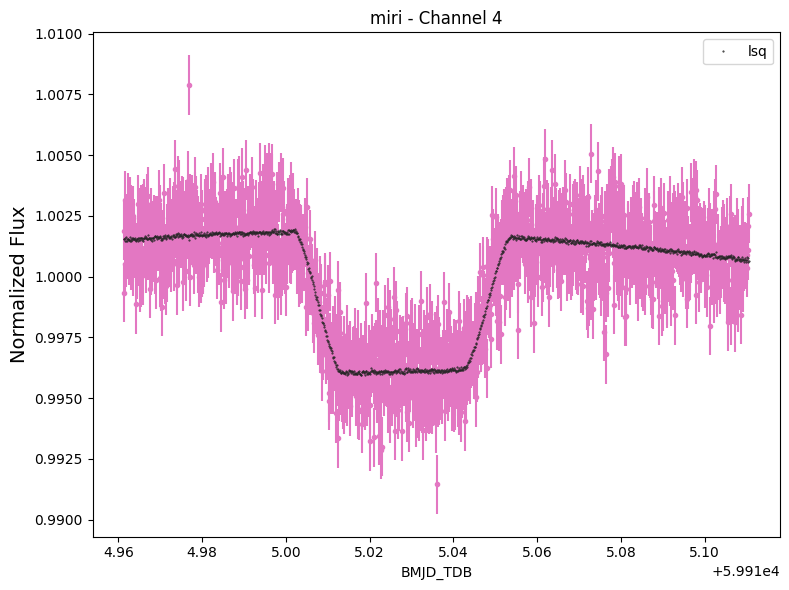

Saving results

Starting Channel 6 of 11

Starting lsq fit.
Starting lnprob: 6426.090379464307
Current lnprob =  6451.817353711644
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6451.817353711644
       x: [ 6.058e-03  2.174e-01 -2.569e-01  9.958e-01  6.953e-03
           -4.569e-03 -3.310e-03  1.311e+00]
     nit: 5
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-3.100e-06 -1.095e-01 ...  1.329e-03 -1.179e-02]]
    nfev: 384

Ending lnprob: 6451.817353711644
Reduced Chi-squared: 1.006876622898073

LSQ RESULTS:
fp: 0.006058378638508782
AmpCos1: 0.21738681619383082
AmpSin1: -0.2569368110965677
c0: 0.9957694643121153
c1: 0.006952823204547807
ypos: -0.004568812024805231
ywidth: -0.003310343407359676
scatter_mult: 1.3112458839372398; 1377.4330825834513 ppm



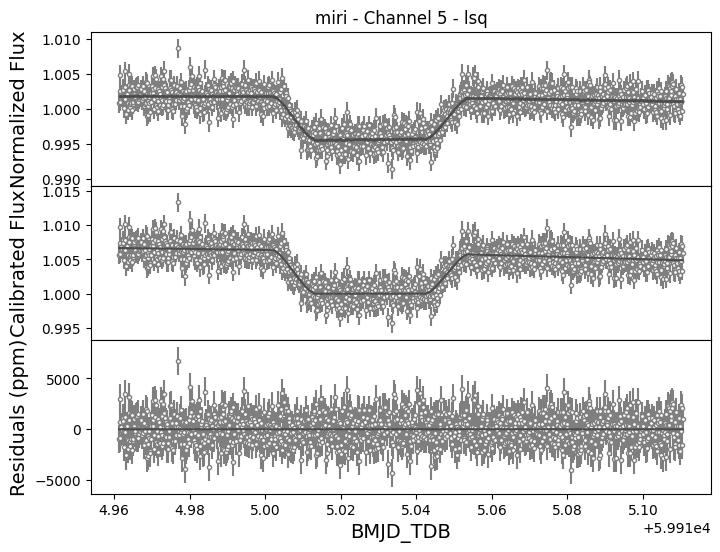

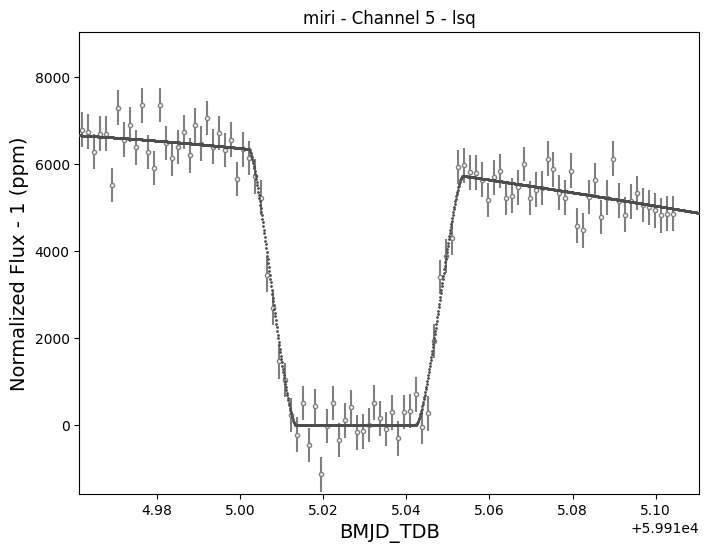

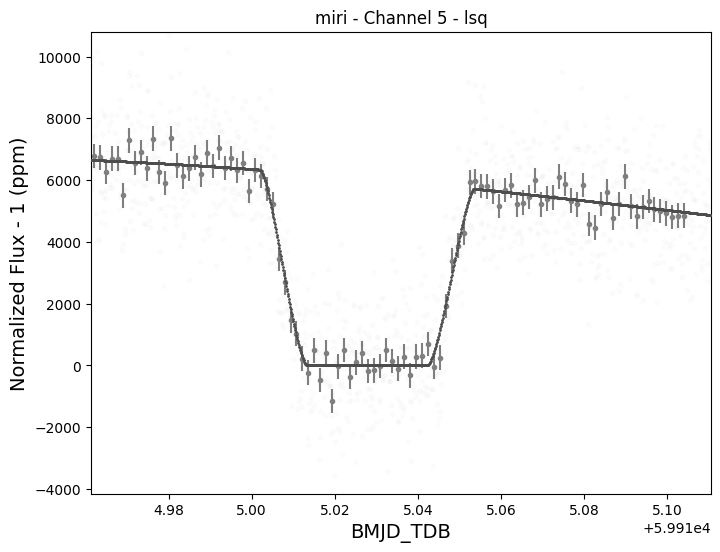

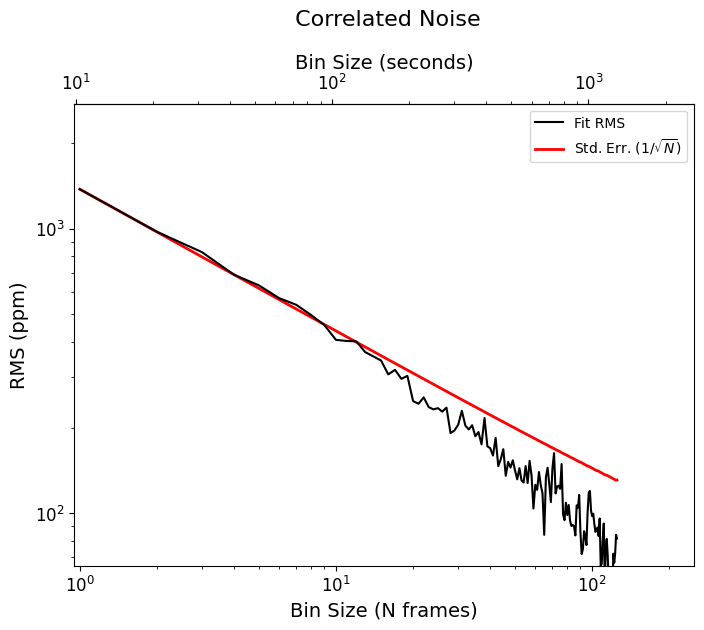

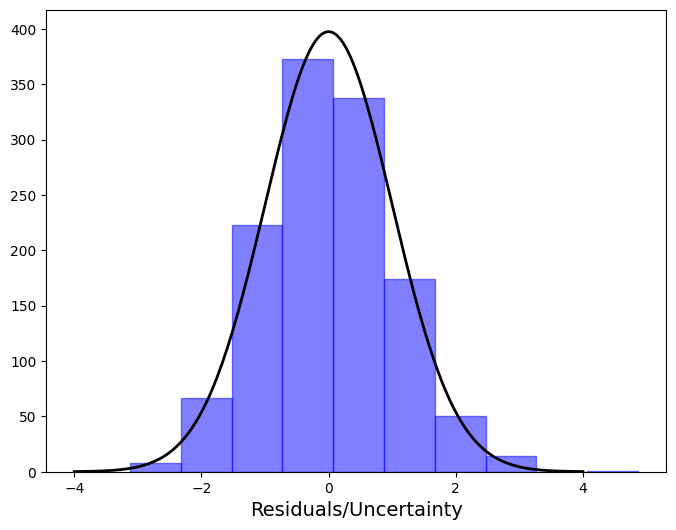

Completed lsq fit.
-------------------------


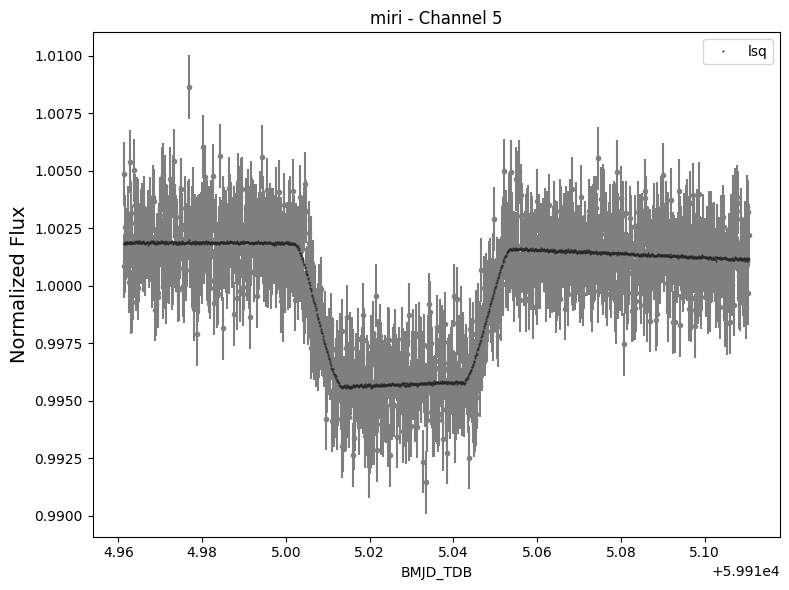

Saving results

Starting Channel 7 of 11

Starting lsq fit.
Starting lnprob: 6302.492756771442

Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6305.975900991988
       x: [ 6.248e-03  4.309e-01 -3.758e-01  9.958e-01  1.458e-02
            4.898e-03 -1.721e-03  1.324e+00]
     nit: 8
   direc: [[ 3.798e-05  1.137e-01 ...  2.306e-04 -4.981e-04]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-3.691e-05 -5.441e-02 ... -1.645e-04 -5.268e-04]]
    nfev: 724

Ending lnprob: 6305.975900991988
Reduced Chi-squared: 1.0064926515076544

LSQ RESULTS:
fp: 0.006247603392800832
AmpCos1: 0.430886349654868
AmpSin1: -0.3758018723326608
c0: 0.9957591317978199
c1: 0.0145788579795402
ypos: 0.004897783151090583
ywidth: -0.001720756818830585
scatter_mult: 1.324102605667957; 1547.2356049884017 ppm



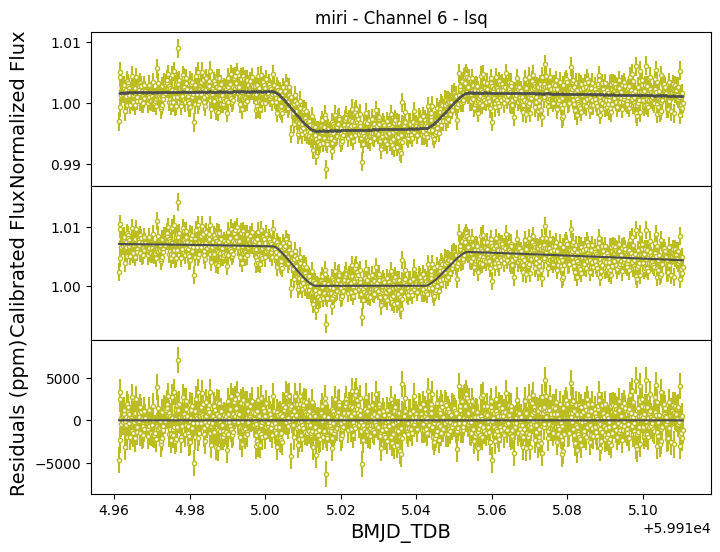

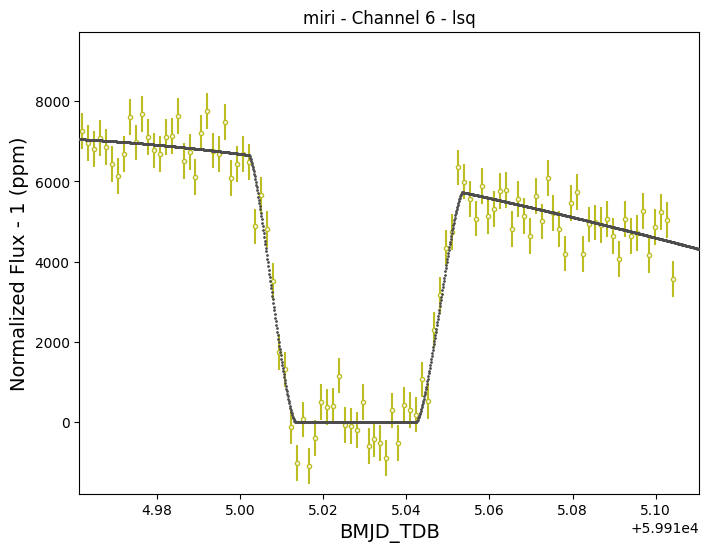

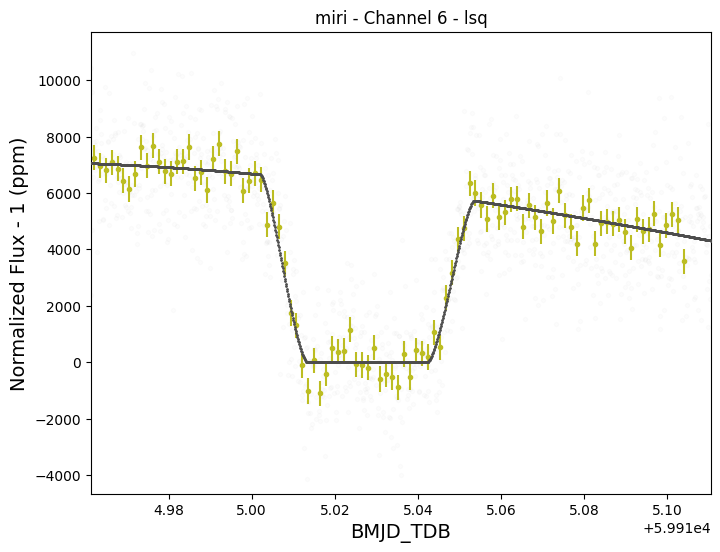

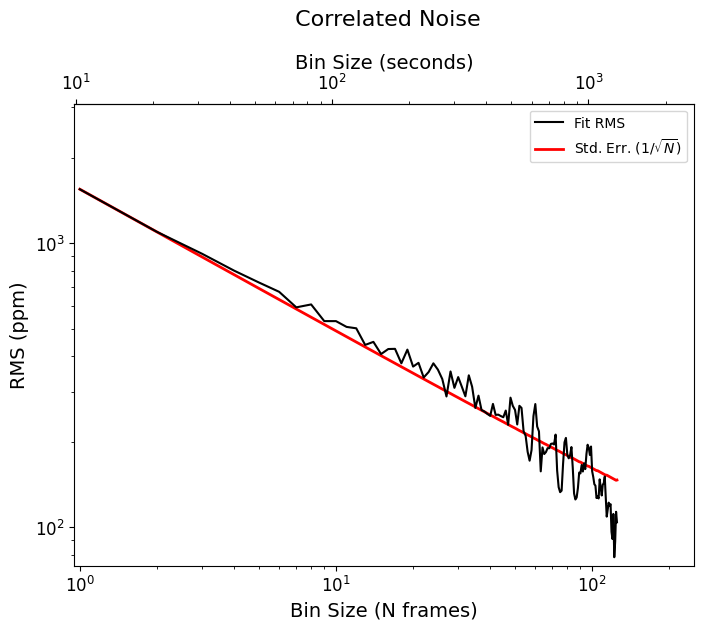

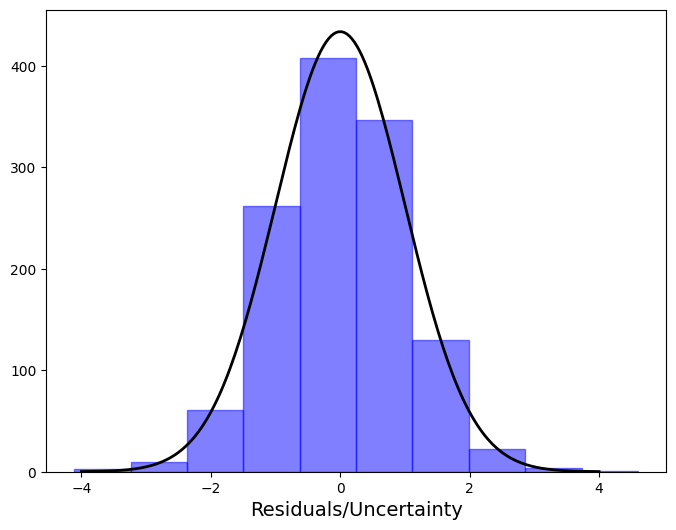

Completed lsq fit.
-------------------------


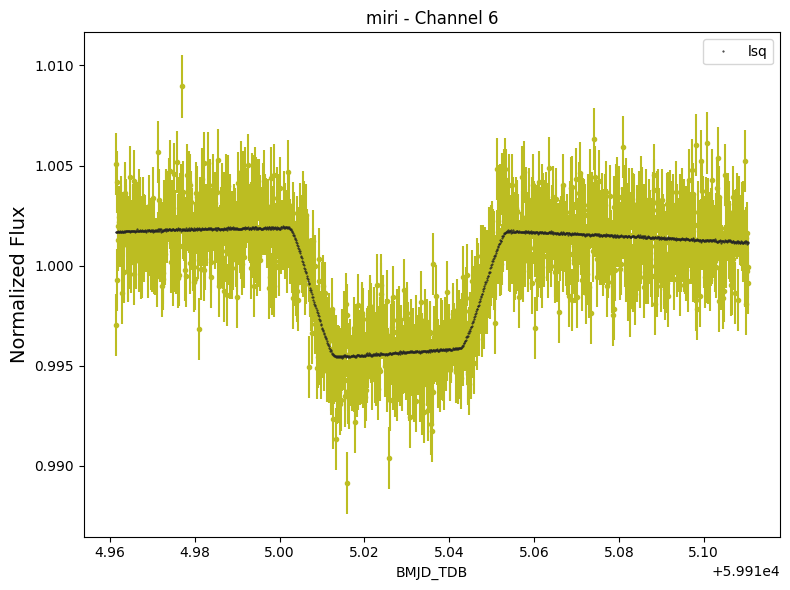

Saving results

Starting Channel 8 of 11

Starting lsq fit.
Starting lnprob: 6074.872749932324
Current lnprob =  6090.578893027966
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6090.578893027966
       x: [ 6.666e-03  6.813e-01 -1.410e-01  9.955e-01  6.357e-04
           -2.425e-04  9.321e-03  1.390e+00]
     nit: 7
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 5.228e-05  1.125e-01 ...  2.938e-04 -1.261e-03]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-2.840e-05 -6.088e-02 ... -1.044e-04 -6.912e-04]]
    nfev: 570

Ending lnprob: 6090.578893027966
Reduced Chi-squared: 1.0066344507537093

LSQ RESULTS:
fp: 0.006666414266696172
AmpCos1: 0.6812527716452277
AmpSin1: -0.14104443827143434
c0: 0.9954773002912803
c1: 0.0006356691555836474
ypos: -0.0002424671617198249
ywidth: 0.00932058554267033
scatter_mult: 1.3901570860047536; 1838.4535958486304 ppm



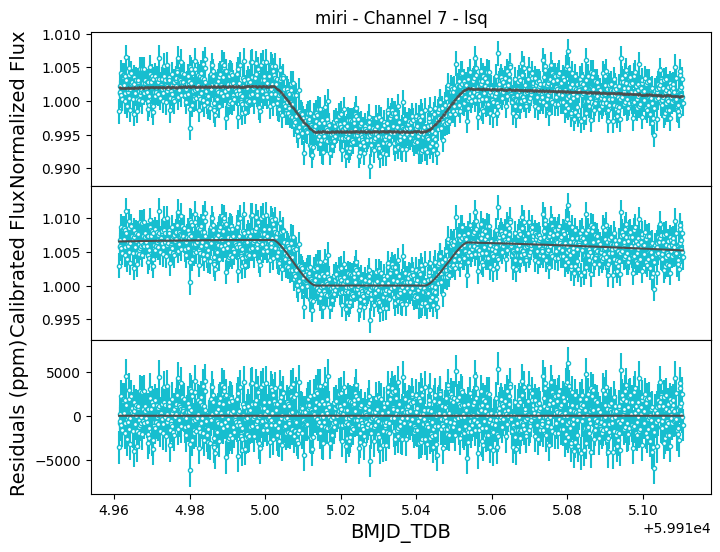

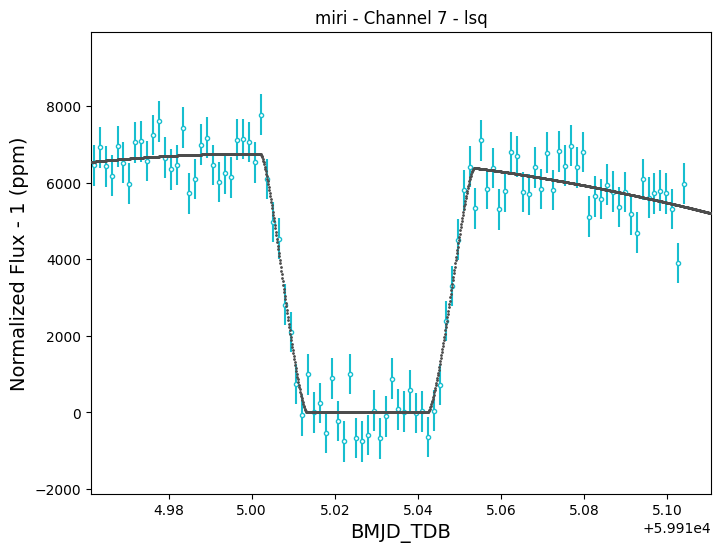

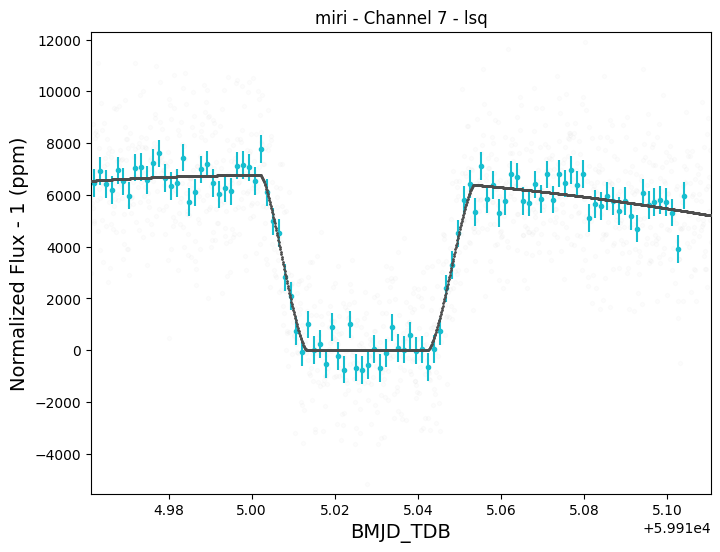

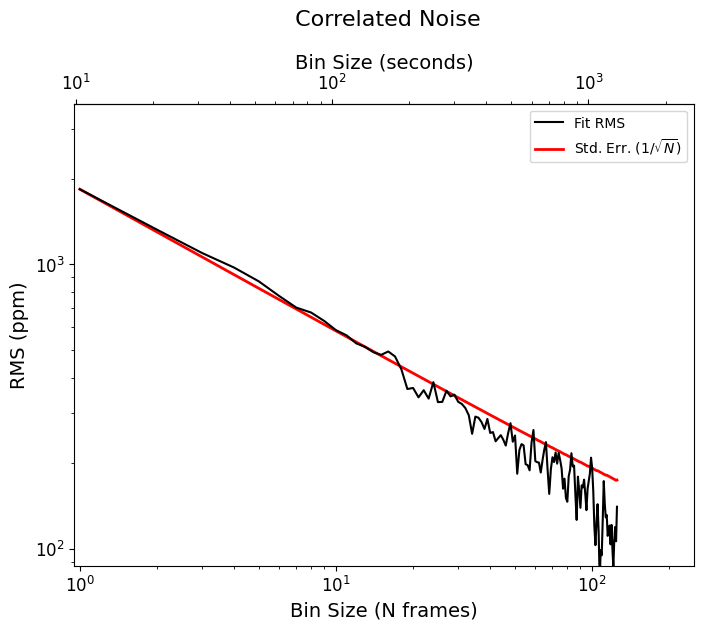

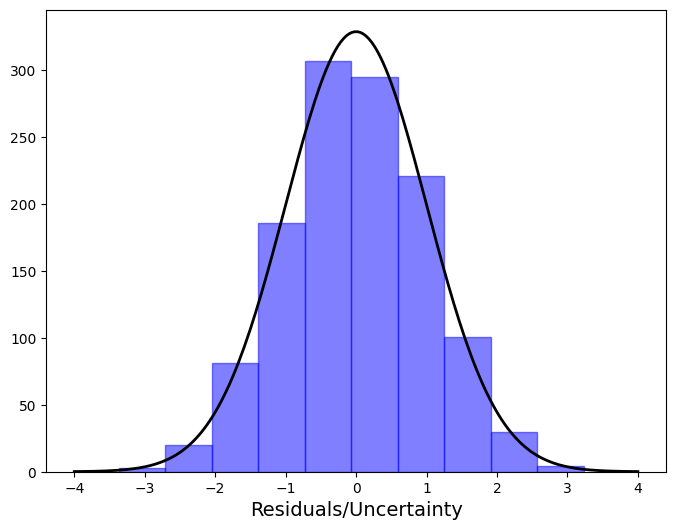

Completed lsq fit.
-------------------------


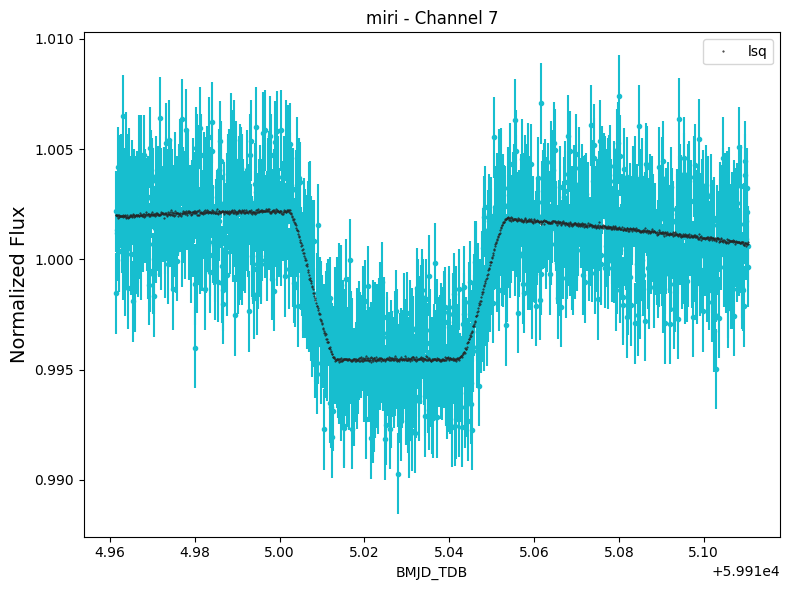

Saving results

Starting Channel 9 of 11

Starting lsq fit.
Starting lnprob: 5911.134990202872

Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -5920.045442503006
       x: [ 6.969e-03  5.472e-01 -2.277e-01  9.953e-01  8.096e-03
            3.831e-03  2.939e-02  1.405e+00]
     nit: 9
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [-1.343e-05  2.861e-03 ...  6.327e-05  4.623e-06]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-1.394e-05 -2.614e-02 ... -6.393e-05 -1.080e-04]]
    nfev: 831

Ending lnprob: 5920.045442503006
Reduced Chi-squared: 1.006542517310492

LSQ RESULTS:
fp: 0.006968615441899703
AmpCos1: 0.5472004513742457
AmpSin1: -0.22771769250449975
c0: 0.9952607643942262
c1: 0.008096275649952129
ypos: 0.0038313260117163335
ywidth: 0.029393685201779613
scatter_mult: 1.4047225966790435; 2105.168054041782 ppm



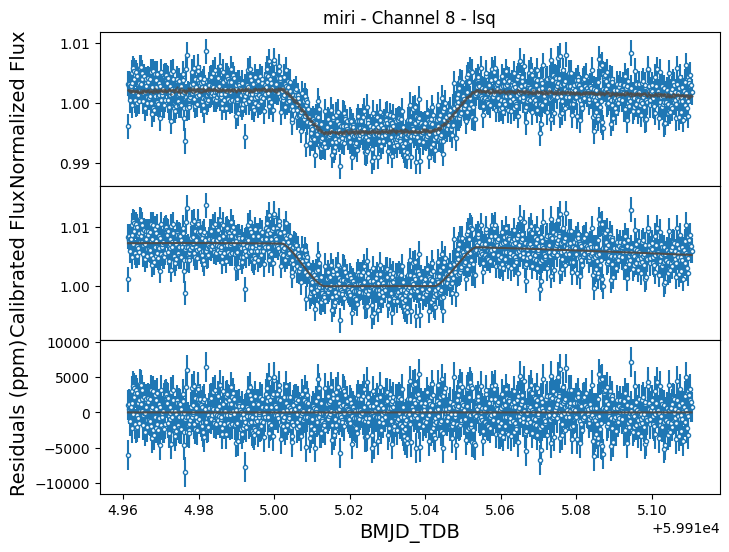

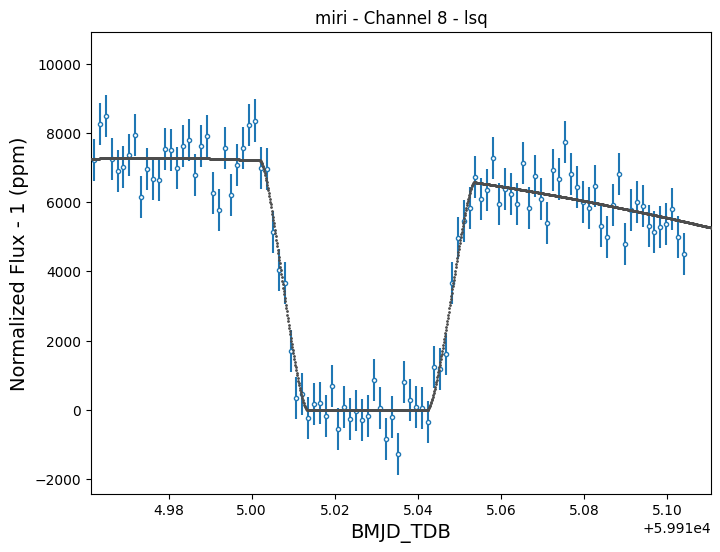

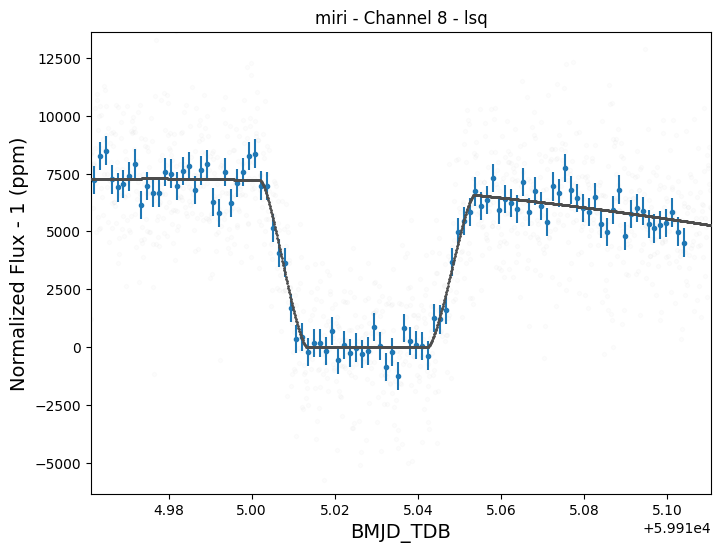

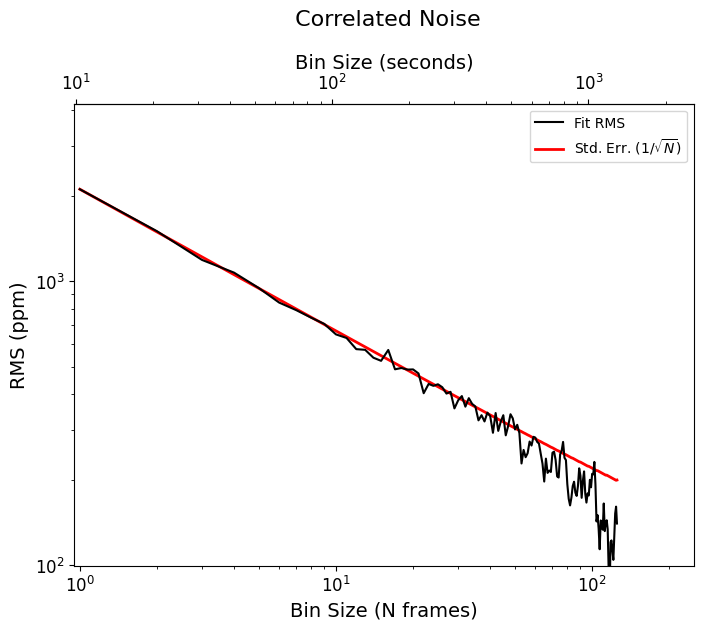

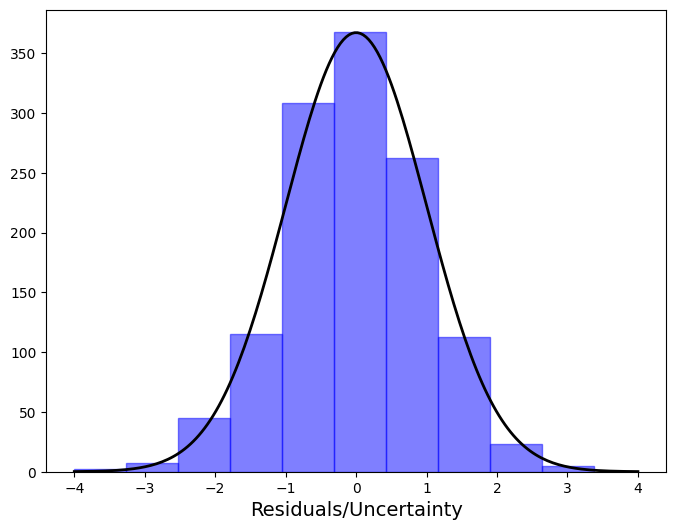

Completed lsq fit.
-------------------------


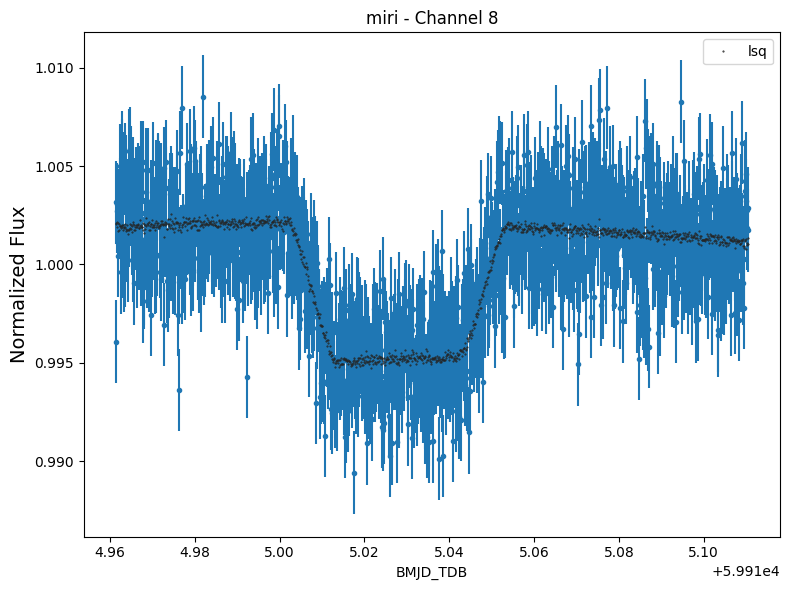

Saving results

Starting Channel 10 of 11

Starting lsq fit.
Starting lnprob: 5780.584531391984

Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -5789.021323555346
       x: [ 7.383e-03  9.588e-01 -9.429e-02  9.951e-01  5.087e-04
           -2.762e-02  1.686e-02  1.407e+00]
     nit: 12
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 1.230e-05  2.402e-02 ...  6.447e-05  2.528e-04]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 3.289e-06  1.090e-02 ...  3.135e-05  4.055e-04]]
    nfev: 1100

Ending lnprob: 5789.021323555346
Reduced Chi-squared: 1.0062027115098275

LSQ RESULTS:
fp: 0.007382977710052934
AmpCos1: 0.9588474640656957
AmpSin1: -0.0942874305531459
c0: 0.9950912057245713
c1: 0.0005087173562189527
ypos: -0.027621699580692636
ywidth: 0.016862802804866028
scatter_mult: 1.4066271549961276; 2337.7061208717614 ppm



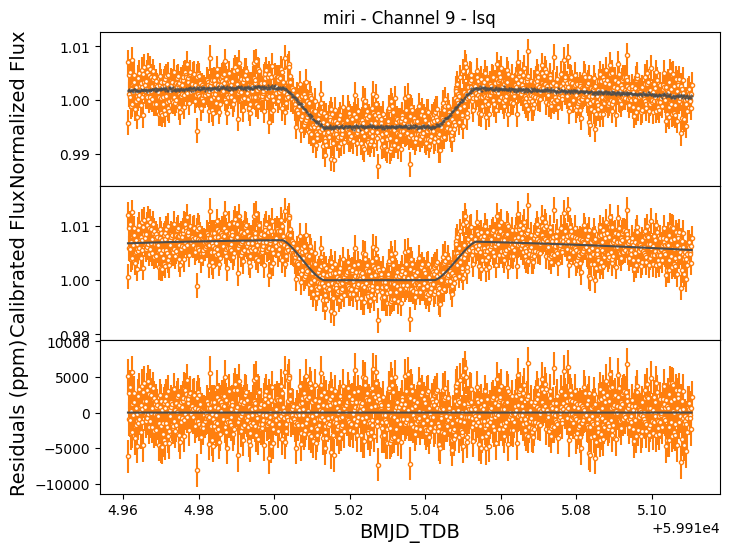

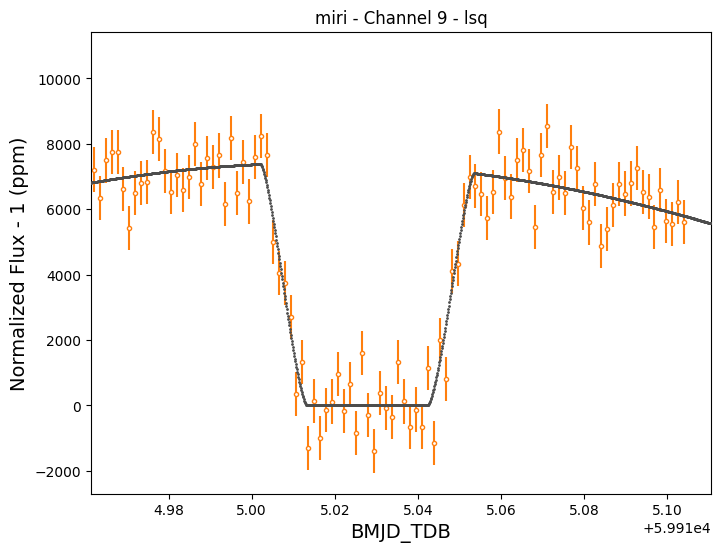

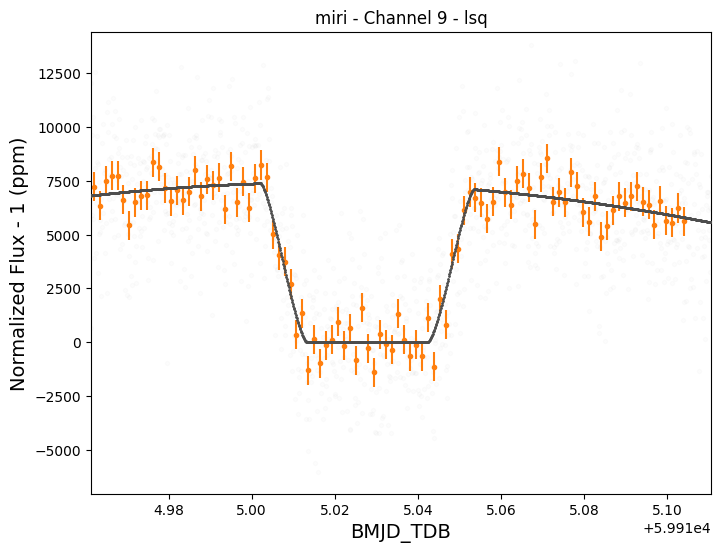

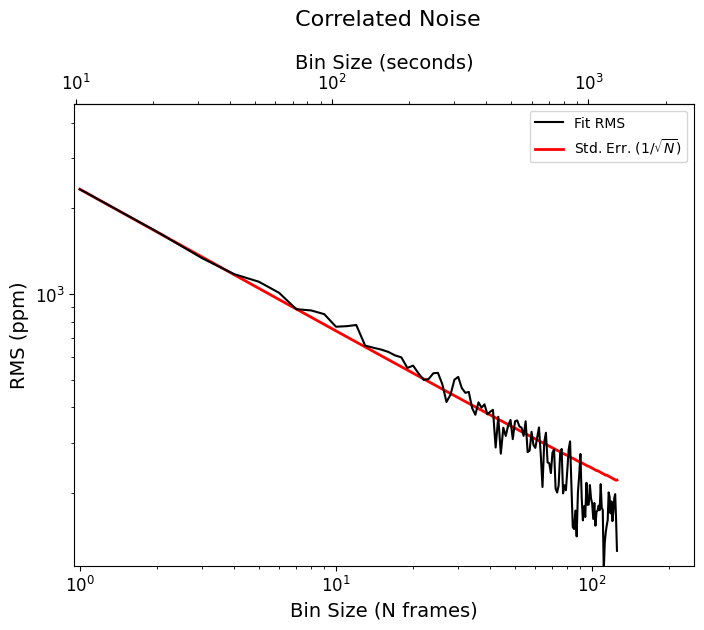

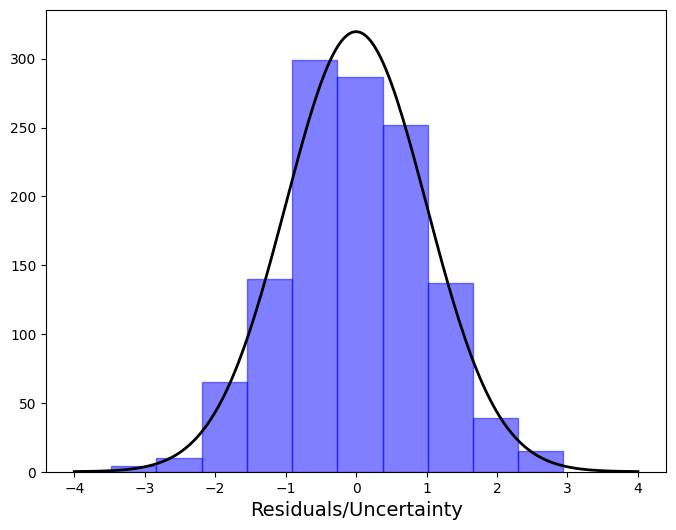

Completed lsq fit.
-------------------------


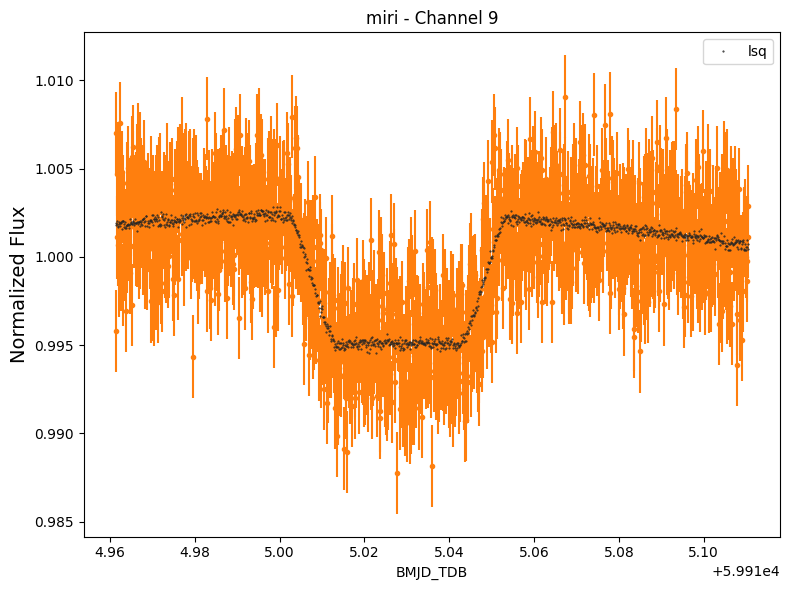

Saving results

Starting Channel 11 of 11

Starting lsq fit.
Starting lnprob: 5435.808962200424

Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -5449.366158337059
       x: [ 6.762e-03  2.003e-01 -1.014e-01  9.952e-01  1.643e-04
           -3.880e-03  1.587e-02  1.518e+00]
     nit: 5
   direc: [[-1.854e-04 -3.530e-01 ... -8.274e-04 -1.807e-03]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-1.631e-04 -1.570e-02 ...  3.298e-05  1.020e-04]]
    nfev: 428

Ending lnprob: 5449.366158337059
Reduced Chi-squared: 1.006587233440526

LSQ RESULTS:
fp: 0.0067623514135515626
AmpCos1: 0.20033985112471964
AmpSin1: -0.10144397906417726
c0: 0.9952350789190317
c1: 0.00016430386511535257
ypos: -0.003879798486955414
ywidth: 0.01587461276518028
scatter_mult: 1.5180486914176279; 3069.7526068605953 ppm



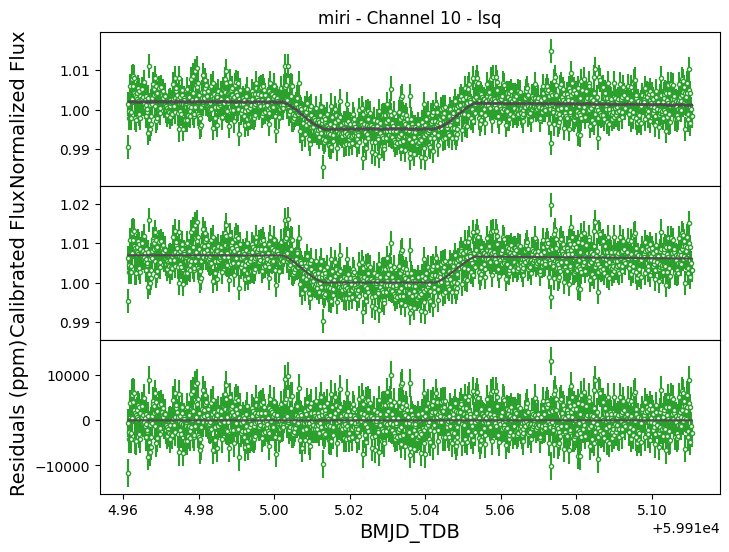

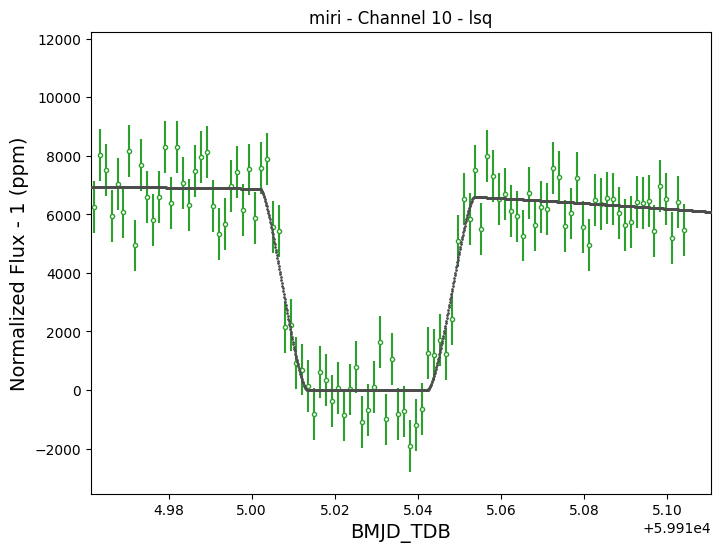

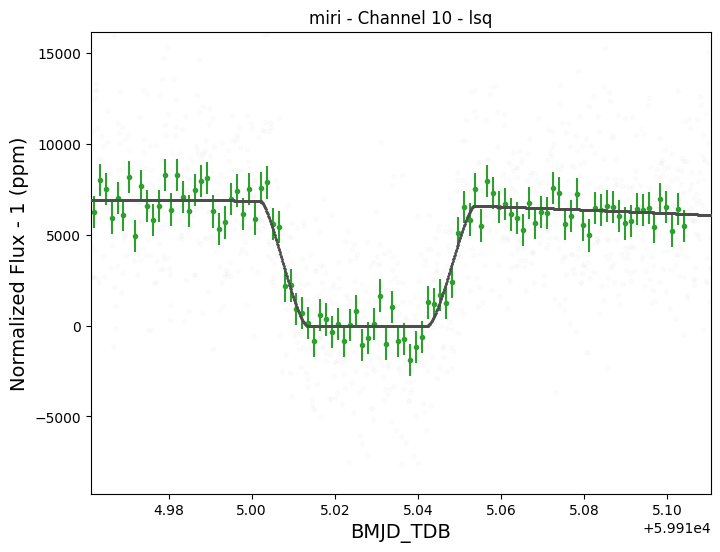

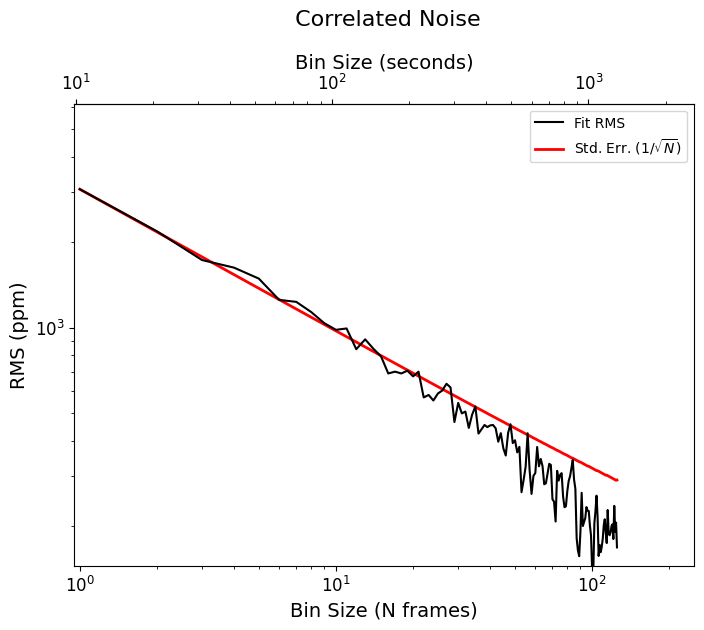

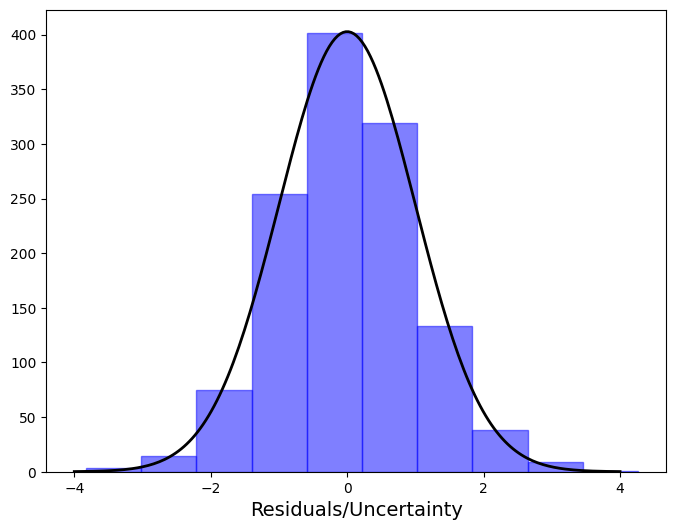

Completed lsq fit.
-------------------------


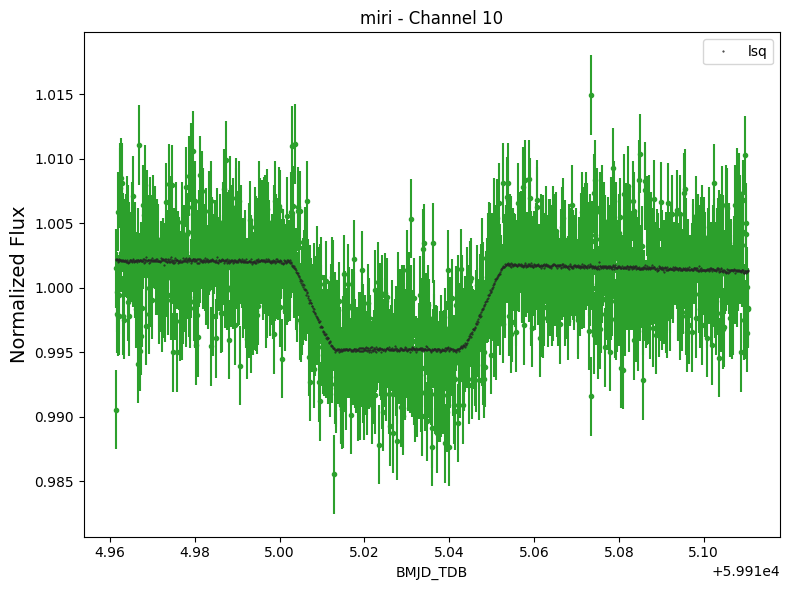

Saving results

Total time (min): 1.84


In [10]:
s5_meta = eureka.S5_lightcurve_fitting.s5_fit.fitlc(eventlabel)

# Gathering together spectroscopic fits

Now that we've completed fits to the 11 spectroscopic channels, we want an easy way of seeing how different parameters vary with wavelength. Of particular interest is the eclipse depth (`fp`) — the variations in eclipse depth as a function of wavelength is called an emission spectrum and can be used to determine the presence and abundance of molecules in the atmosphere of an exoplanet. Because we only used the `lsq` optimization algorithm above, our emission spectrum will not have error bars. If you want to know what the spectrum looks like with error bars, you'll have to re-run your spectroscopic fits above using a sampler like dynesty.

## Setting the Stage 6 "Eureka! Control File" (ECF)

**This determines what will happen during Eureka!'s Stage 6**

To begin, please first copy below the contents of the ECF template for MIRI/LRS from the `S6_template.ecf` file in the ECF demos folder on [GitHub](https://github.com/kevin218/Eureka/tree/main/demos/JWST).

The most important parameters and their recommended settings are described below, but more context can be found on the [Eureka! documentation website](https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-6).

1. Set `y_params` to `['fp']`. Eureka! is able to plot any of the `'free'` parameters from your fits as a function of wavelength, but the only one we're really interested in here is `fp`.
2. Set `y_scalars` to `[1e6]` so that units of ppm are used for a plot that is easier to read.
3. You can safely ignore the settings in the "Scale height parameters" chunk and "Model" chunk as they are not relevant for our purposes.
4. Set `topdir` to the same value as you used in your Stage 5 spectroscopic fits.

That's all we need to change for our purposes here, and all the other parameters can be left at their default settings.

In [11]:
s6_ecf_contents = f"""
# Eureka! Control File for Stage 6: Spectra Plotting

allapers        False  # Run S6 on all of the apertures considered in S5? Otherwise will use newest output in the inputdir

# Plotting parameters
y_params        ['fp']  # The parameter name as entered in your EPF file in Stage 5
y_labels        None   # The formatted string you want on the y-label
y_label_units   None   # The formatted string for the units you want on the y-label - e.g., (ppm), (seconds), '(days$^{-1})$', etc.. Set to None to automatically add any implied units from y_scalars (e.g. ppm), or set to '' to force no units.
y_scalars       [1e6]   # Can be used to convert to percent (100), ppm (1e6), etc.
x_unit          um     # Options include any measurement of light included in astropy.units.spectral (e.g. um, nm, Hz, etc.)

# Tabulating parameters
ncol            4      # The number of columns you want in your LaTeX formatted tables

# Diagnostics
isplots_S6      5      # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
testing_S6      False
hide_plots      False   # If True, plots will automatically be closed rather than popping up

# Project directory
topdir          /content/drive/MyDrive/SSW2023/MIRI

# Model to plot overtop (csv with col 1 as wavelength in microns, col 2 in the same units as the plotted spectrum, any headers preceded by a #)
model_spectrum  None   # Set to None if no model should be plotted

# Directories relative to project dir
inputdir        Stage5
outputdir       Stage6
"""

with open(f'S6_{eventlabel}.ecf', 'w') as f:
    f.write(s6_ecf_contents)

## Running Eureka!'s Stage 6

The following cell will run Eureka!'s Stage 6 using the settings you defined above. Note that your ECF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The following stage should take &#8810;1 minute to complete on Google Colab.


Starting Stage 6: Light Curve Fitting

Input directory: /content/drive/MyDrive/SSW2023/MIRI/Stage5/S5_2023-07-25_miri_run1/ap11_bg5/
Output directory: /content/drive/MyDrive/SSW2023/MIRI/Stage6/S6_2023-07-25_miri_run1/ap11_bg5/
Copying S6 control file
Plotting fp...


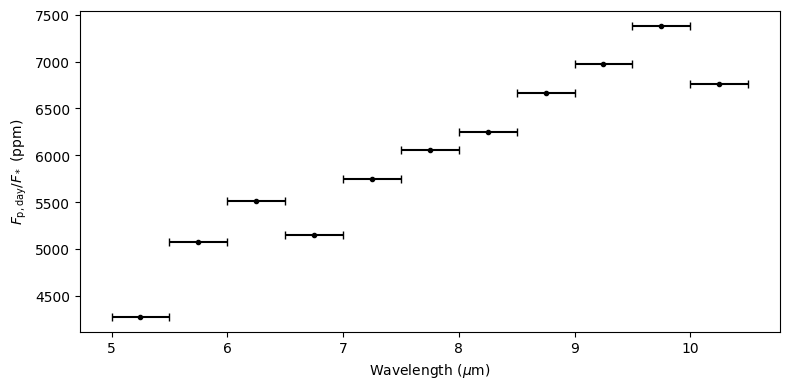

  Saving results as an astropy table
  Saving results as a LaTeX table
Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage6/S6_2023-07-25_miri_run1/ap11_bg5/S6_miri_ap11_bg5_LC.h5
Saving results

Total time (min): 0.03


In [12]:
s6_meta = eureka.S6_planet_spectra.s6_spectra.plot_spectra(eventlabel)

As you can see from your emission spectrum, the eclipse depth increases with wavelength. This is generally true of thermal emission spectra because the emission spectrum is approximately a ratio of blackbody functions which increases with increasing wavelength. You should also see a decrease in the eclipse depth around 6.5 microns - this feature is indicative of water in the atmosphere of WASP-43b. In the next workshops, we'll learn how we can use forward models and retrievals to interpret transmission and/or emission spectra.

# Double-checking work against ERS results

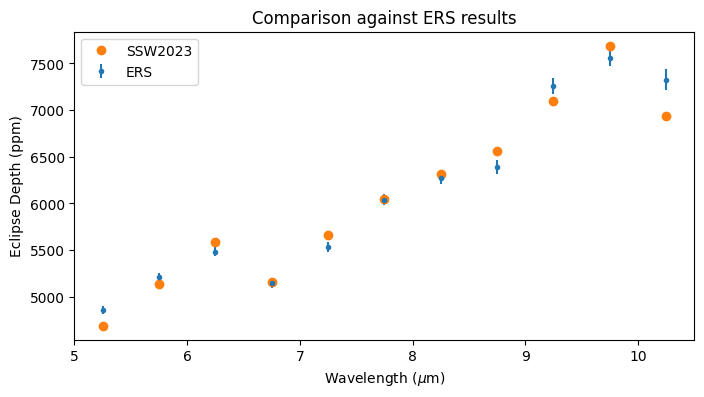

The eclipse spectrum is fairly closely reproduced at all wavelengths. The ERS results are my (TJB's) own